# Environment Setup

### Mounting Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dependencies

In [ ]:
# Install dependencies
!pip install kaggle xgboost dagshub mlflow==2.22.0 -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install shap -Uq

### Dagshub / MLflow Setup

In [ ]:
import dagshub
dagshub.init(repo_owner='Cimbir', repo_name='Store-Sales-Forecasting', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=72e6e6ea-eb2f-4715-9098-c96ece5945b1&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=d8d82a811e88e11040f4c3d68cd71c2eb620f64560ec58fa1af4258c73115281




Accessing as vvaza22

Initialized MLflow to track repo "Cimbir/Store-Sales-Forecasting"

Repository Cimbir/Store-Sales-Forecasting initialized!

### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from abc import abstractmethod
from sklearn.metrics import mean_absolute_error
import mlflow

In [ ]:
RANDOM_STATE = 42

### Download Dataset

In [ ]:
FILEPATH = "/content/drive/MyDrive/ml/assignments/final"
COMPETITION = "walmart-recruiting-store-sales-forecasting"
DATA_PATH = "/content/data"

In [ ]:
!mkdir -p ~/.kaggle
!cp {FILEPATH}/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c {COMPETITION}

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 533MB/s]


In [ ]:
!mkdir -p {DATA_PATH}
!unzip -o {COMPETITION}.zip -d {DATA_PATH}

Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: /content/data/features.csv.zip  
  inflating: /content/data/sampleSubmission.csv.zip  
  inflating: /content/data/stores.csv  
  inflating: /content/data/test.csv.zip  
  inflating: /content/data/train.csv.zip  


In [ ]:
!mkdir -p {DATA_PATH}/csv
!cp {DATA_PATH}/stores.csv {DATA_PATH}/csv/
!unzip -o {DATA_PATH}/train.csv.zip -d {DATA_PATH}/csv
!unzip -o {DATA_PATH}/features.csv.zip -d {DATA_PATH}/csv
!unzip -o {DATA_PATH}/test.csv.zip -d {DATA_PATH}/csv

Archive:  /content/data/train.csv.zip
  inflating: /content/data/csv/train.csv  
Archive:  /content/data/features.csv.zip
  inflating: /content/data/csv/features.csv  
Archive:  /content/data/test.csv.zip
  inflating: /content/data/csv/test.csv  


# Data Preparation

### Merge data to create DataFrame

In [ ]:
train = pd.read_csv(f'{DATA_PATH}/csv/train.csv')
stores = pd.read_csv(f'{DATA_PATH}/csv/stores.csv')
features = pd.read_csv(f'{DATA_PATH}/csv/features.csv')

In [ ]:
df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.drop('IsHoliday_y', axis=1)
df.head()

Store  Dept        Date  Weekly_Sales  IsHoliday_x  Temperature  \
0      1     1  2010-02-05      24924.50        False        42.31   
1      1     1  2010-02-12      46039.49         True        38.51   
2      1     1  2010-02-19      41595.55        False        39.93   
3      1     1  2010-02-26      19403.54        False        46.63   
4      1     1  2010-03-05      21827.90        False        46.50   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        NaN        NaN        NaN        NaN        NaN   
1       2.548        NaN        NaN        NaN        NaN        NaN   
2       2.514        NaN        NaN        NaN        NaN        NaN   
3       2.561        NaN        NaN        NaN        NaN        NaN   
4       2.625        NaN        NaN        NaN        NaN        NaN   

          CPI  Unemployment Type    Size  
0  211.096358         8.106    A  151315  
1  211.242170         8.106    A  151315  
2  211.289143         8.106    A  151315  
3  211.319643         8.106    A  151315  
4  211.350143         8.106    A  151315

In [ ]:
df.shape

(421570, 16)

### Visualize Average Weekly Sales in the Whole Dataset

In [ ]:
df_holiday = df[df['IsHoliday_x'] == True].copy()
df_holiday.head()

Store  Dept        Date  Weekly_Sales  IsHoliday_x  Temperature  \
1       1     1  2010-02-12      46039.49         True        38.51   
31      1     1  2010-09-10      18194.74         True        78.69   
42      1     1  2010-11-26      18820.29         True        64.52   
47      1     1  2010-12-31      19124.58         True        48.43   
53      1     1  2011-02-11      37887.17         True        36.39   

    Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
1        2.548        NaN        NaN        NaN        NaN        NaN   
31       2.565        NaN        NaN        NaN        NaN        NaN   
42       2.735        NaN        NaN        NaN        NaN        NaN   
47       2.943        NaN        NaN        NaN        NaN        NaN   
53       3.022        NaN        NaN        NaN        NaN        NaN   

           CPI  Unemployment Type    Size  
1   211.242170         8.106    A  151315  
31  211.495190         7.787    A  151315  
42  211.748433         7.838    A  151315  
47  211.404932         7.838    A  151315  
53  212.936705         7.742    A  151315

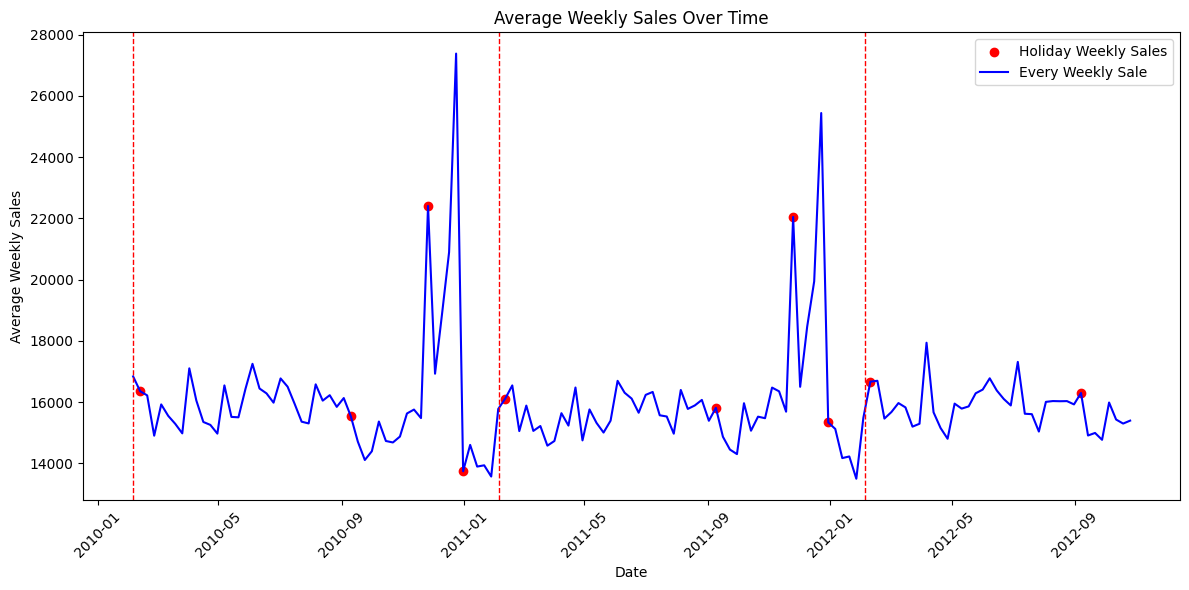

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df_holiday = df[df['IsHoliday_x'] == True].copy()

avg_sales_over_time = df.groupby('Date')['Weekly_Sales'].mean()
avg_sales_over_time_holiday = df_holiday.groupby('Date')['Weekly_Sales'].mean()

plt.figure(figsize=(12, 6))

plt.scatter(avg_sales_over_time_holiday.index, avg_sales_over_time_holiday.values, color='red', label='Holiday Weekly Sales')
plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='blue', label='Every Weekly Sale')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales Over Time')
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical lines for the end of each year
years = pd.to_datetime(avg_sales_over_time.index).year.unique()
for year in years:
    end_of_year = pd.to_datetime(f'{year}-02-05')
    plt.axvline(end_of_year, color='red', linestyle='--', lw=1)

plt.show()

### Test/Train Dataset Split

In [ ]:
SPLIT_DATE = '2011-09-01'

df['Date'] = pd.to_datetime(df['Date'])

# Train dataset
train = df[(df['Date'] < SPLIT_DATE)]

# Test dataset
test = df[(df['Date'] >= SPLIT_DATE)]
test.reset_index(drop=True, inplace=True)

In [ ]:
train.head()

Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50        False        42.31       2.572   
1      1     1 2010-02-12      46039.49         True        38.51       2.548   
2      1     1 2010-02-19      41595.55        False        39.93       2.514   
3      1     1 2010-02-26      19403.54        False        46.63       2.561   
4      1     1 2010-03-05      21827.90        False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment Type    Size  
0         8.106    A  151315  
1         8.106    A  151315  
2         8.106    A  151315  
3         8.106    A  151315  
4         8.106    A  151315

In [ ]:
train.tail()

Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  \
421504     45    98 2011-07-29        599.03        False        81.31   
421505     45    98 2011-08-05        982.60        False        78.22   
421506     45    98 2011-08-12        827.40        False        77.00   
421507     45    98 2011-08-19        535.68        False        72.98   
421508     45    98 2011-08-26        385.96        False        72.55   

        Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
421504       3.829        NaN        NaN        NaN        NaN        NaN   
421505       3.842        NaN        NaN        NaN        NaN        NaN   
421506       3.812        NaN        NaN        NaN        NaN        NaN   
421507       3.747        NaN        NaN        NaN        NaN        NaN   
421508       3.704        NaN        NaN        NaN        NaN        NaN   

               CPI  Unemployment Type    Size  
421504  186.295596         8.625    B  118221  
421505  186.373404         8.625    B  118221  
421506  186.451211         8.625    B  118221  
421507  186.509307         8.625    B  118221  
421508  186.564117         8.625    B  118221

In [ ]:
test.head()

Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0      1     1 2011-09-02      15277.27        False        87.83       3.533   
1      1     1 2011-09-09      17746.68         True        76.00       3.546   
2      1     1 2011-09-16      18535.48        False        79.94       3.526   
3      1     1 2011-09-23      17859.30        False        75.80       3.467   
4      1     1 2011-09-30      18337.68        False        79.69       3.355   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  215.797141   
1        NaN        NaN        NaN        NaN        NaN  215.861056   
2        NaN        NaN        NaN        NaN        NaN  216.041053   
3        NaN        NaN        NaN        NaN        NaN  216.375825   
4        NaN        NaN        NaN        NaN        NaN  216.710597   

   Unemployment Type    Size  
0         7.962    A  151315  
1         7.962    A  151315  
2         7.962    A  151315  
3         7.962    A  151315  
4         7.962    A  151315

### Visualize Data Split

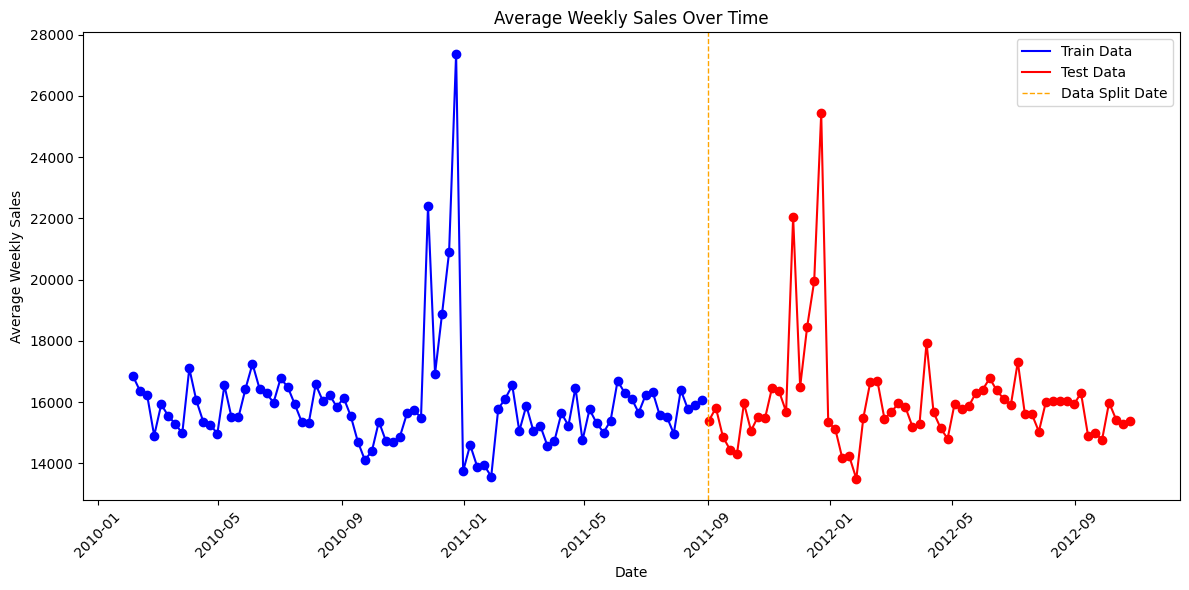

In [ ]:
plt.figure(figsize=(12, 6))

# Plot train data
avg_train_sales = train.groupby('Date')['Weekly_Sales'].mean()
plt.scatter(avg_train_sales.index, avg_train_sales.values, color='blue')
plt.plot(avg_train_sales.index, avg_train_sales.values, color='blue', label='Train Data')

# Plot test data
avg_test_sales = test.groupby('Date')['Weekly_Sales'].mean()
plt.scatter(avg_test_sales.index, avg_test_sales.values, color='red')
plt.plot(avg_test_sales.index, avg_test_sales.values, color='red', label='Test Data')

# Add Split Line
plt.axvline(pd.to_datetime(SPLIT_DATE), color='orange', linestyle='--', lw=1, label='Data Split Date')

plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

### Prepare X_train, y_train

In [ ]:
X_train = train.copy().sort_values(by=['Store', 'Dept', 'Date'])
y_train = X_train['Weekly_Sales']
X_train.drop('Weekly_Sales', axis=1, inplace=True)

In [ ]:
X_train.head()

Store  Dept       Date  IsHoliday_x  Temperature  Fuel_Price  MarkDown1  \
0      1     1 2010-02-05        False        42.31       2.572        NaN   
1      1     1 2010-02-12         True        38.51       2.548        NaN   
2      1     1 2010-02-19        False        39.93       2.514        NaN   
3      1     1 2010-02-26        False        46.63       2.561        NaN   
4      1     1 2010-03-05        False        46.50       2.625        NaN   

   MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment Type  \
0        NaN        NaN        NaN        NaN  211.096358         8.106    A   
1        NaN        NaN        NaN        NaN  211.242170         8.106    A   
2        NaN        NaN        NaN        NaN  211.289143         8.106    A   
3        NaN        NaN        NaN        NaN  211.319643         8.106    A   
4        NaN        NaN        NaN        NaN  211.350143         8.106    A   

     Size  
0  151315  
1  151315  
2  151315  
3  151315  
4  151315

In [ ]:
y_train.head()

0    24924.50
1    46039.49
2    41595.55
3    19403.54
4    21827.90
Name: Weekly_Sales, dtype: float64

### Prepare X_test, y_test

In [ ]:
# Sort to get unique sequence
X_test = test.copy().sort_values(by=['Store', 'Dept', 'Date'])
y_test = X_test['Weekly_Sales']
X_test.drop('Weekly_Sales', axis=1, inplace=True)

In [ ]:
test

Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  \
0           1     1 2011-09-02      15277.27        False        87.83   
1           1     1 2011-09-09      17746.68         True        76.00   
2           1     1 2011-09-16      18535.48        False        79.94   
3           1     1 2011-09-23      17859.30        False        75.80   
4           1     1 2011-09-30      18337.68        False        79.69   
...       ...   ...        ...           ...          ...          ...   
180962     45    98 2012-09-28        508.37        False        64.88   
180963     45    98 2012-10-05        628.10        False        64.89   
180964     45    98 2012-10-12       1061.02        False        54.47   
180965     45    98 2012-10-19        760.01        False        56.47   
180966     45    98 2012-10-26       1076.80        False        58.85   

        Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0            3.533        NaN        NaN        NaN        NaN        NaN   
1            3.546        NaN        NaN        NaN        NaN        NaN   
2            3.526        NaN        NaN        NaN        NaN        NaN   
3            3.467        NaN        NaN        NaN        NaN        NaN   
4            3.355        NaN        NaN        NaN        NaN        NaN   
...            ...        ...        ...        ...        ...        ...   
180962       3.997    4556.61      20.64       1.50    1601.01    3288.25   
180963       3.985    5046.74        NaN      18.82    2253.43    2340.01   
180964       4.000    1956.28        NaN       7.89     599.32    3990.54   
180965       3.969    2004.02        NaN       3.18     437.73    1537.49   
180966       3.882    4018.91      58.08     100.00     211.94     858.33   

               CPI  Unemployment Type    Size  
0       215.797141         7.962    A  151315  
1       215.861056         7.962    A  151315  
2       216.041053         7.962    A  151315  
3       216.375825         7.962    A  151315  
4       216.710597         7.962    A  151315  
...            ...           ...  ...     ...  
180962  192.013558         8.684    B  118221  
180963  192.170412         8.667    B  118221  
180964  192.327265         8.667    B  118221  
180965  192.330854         8.667    B  118221  
180966  192.308899         8.667    B  118221  

[180967 rows x 16 columns]

In [ ]:
X_test.head()

Store  Dept       Date  IsHoliday_x  Temperature  Fuel_Price  MarkDown1  \
0      1     1 2011-09-02        False        87.83       3.533        NaN   
1      1     1 2011-09-09         True        76.00       3.546        NaN   
2      1     1 2011-09-16        False        79.94       3.526        NaN   
3      1     1 2011-09-23        False        75.80       3.467        NaN   
4      1     1 2011-09-30        False        79.69       3.355        NaN   

   MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment Type  \
0        NaN        NaN        NaN        NaN  215.797141         7.962    A   
1        NaN        NaN        NaN        NaN  215.861056         7.962    A   
2        NaN        NaN        NaN        NaN  216.041053         7.962    A   
3        NaN        NaN        NaN        NaN  216.375825         7.962    A   
4        NaN        NaN        NaN        NaN  216.710597         7.962    A   

     Size  
0  151315  
1  151315  
2  151315  
3  151315  
4  151315

In [ ]:
y_test.head()

0    15277.27
1    17746.68
2    18535.48
3    17859.30
4    18337.68
Name: Weekly_Sales, dtype: float64

# Feature Engineering

### Pipeline Parts

In [ ]:
class PrepareFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        # Split date into 3 separate features
        date_field = pd.to_datetime(X['Date'])
        X['Year'] = date_field.dt.year
        X['Month'] = date_field.dt.month
        X['Day'] = date_field.dt.day

        # Represent booleans as 1 and 0
        X['IsHoliday_x'] = X['IsHoliday_x'].astype(int)

        # Cast type into category to let xgboost handle it
        X['Type'] = X['Type'].astype('category')

        # Drop date field not to confuse xgboost
        X.drop('Date', axis=1, inplace=True)

        return X

In [ ]:
class PrepareFeaturesNoCat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        # Split date into 3 separate features
        date_field = pd.to_datetime(X['Date'])
        X['Year'] = date_field.dt.year
        X['Month'] = date_field.dt.month
        X['Day'] = date_field.dt.day

        # Represent booleans as 1 and 0
        X['IsHoliday_x'] = X['IsHoliday_x'].astype(int)

        # Cast type into category to let xgboost handle it
        X['Type'] = X['Type'].map({
          'A': 0,
          'B': 1,
          'C': 2
        })

        # Drop date field not to confuse xgboost
        X.drop('Date', axis=1, inplace=True)

        return X

In [ ]:
class AddLags(BaseEstimator, TransformerMixin):
    def __init__(self, lags):
      self.lags = lags
      self.cache = {}

    def fit(self, X, y):
      X = X.copy()
      X['Date'] = pd.to_datetime(X['Date'])
      X['Weekly_Sales'] = y

      # For each (Store, Dept) cache lags for forecasting
      unique_store_dept = self.get_unique_store_dept(X)

      for store, dept in unique_store_dept:
        subset = X[(X['Store'] == store) & (X['Dept'] == dept)]
        subset = subset.sort_values(by='Date', ascending=True)

        self.cache[(store, dept)] = dict(zip(subset["Date"], subset["Weekly_Sales"]))

      # # Sample cache
      # print("Cache (1,1)", self.cache[(1,1)])

      return self

    def get_unique_store_dept(self, X):
      return X[['Store', 'Dept']].drop_duplicates().to_numpy()

    def get_cache(self, row, lag):
      dt = row['Date']
      store = row['Store']
      dept = row['Dept']

      if not (store, dept) in self.cache:
        return np.nan
      c = self.cache[(store, dept)]
      key = dt - pd.DateOffset(days=lag)

      if not key in c:
        return np.nan

      return c[key]

    # Precondition X should contain Weekly_Sales
    def transform(self, X, y=None):
      X = X.copy()

      # Create lag features
      for lag in self.lags:
        X[f'Weekly_Sales_Lag_{lag}'] = X.apply(lambda row: self.get_cache(row, lag), axis=1)

      return X

In [ ]:
subset = train[(train['Store'] == 1) & (train['Dept'] == 1)]
subset = subset.sort_values(by='Date')
subset

Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  \
0       1     1 2010-02-05      24924.50        False        42.31   
1       1     1 2010-02-12      46039.49         True        38.51   
2       1     1 2010-02-19      41595.55        False        39.93   
3       1     1 2010-02-26      19403.54        False        46.63   
4       1     1 2010-03-05      21827.90        False        46.50   
..    ...   ...        ...           ...          ...          ...   
77      1     1 2011-07-29      15922.41        False        86.83   
78      1     1 2011-08-05      15295.55        False        91.65   
79      1     1 2011-08-12      14539.79        False        90.76   
80      1     1 2011-08-19      14689.24        False        89.94   
81      1     1 2011-08-26      14537.37        False        87.96   

    Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0        2.572        NaN        NaN        NaN        NaN        NaN   
1        2.548        NaN        NaN        NaN        NaN        NaN   
2        2.514        NaN        NaN        NaN        NaN        NaN   
3        2.561        NaN        NaN        NaN        NaN        NaN   
4        2.625        NaN        NaN        NaN        NaN        NaN   
..         ...        ...        ...        ...        ...        ...   
77       3.682        NaN        NaN        NaN        NaN        NaN   
78       3.684        NaN        NaN        NaN        NaN        NaN   
79       3.638        NaN        NaN        NaN        NaN        NaN   
80       3.554        NaN        NaN        NaN        NaN        NaN   
81       3.523        NaN        NaN        NaN        NaN        NaN   

           CPI  Unemployment Type    Size  
0   211.096358         8.106    A  151315  
1   211.242170         8.106    A  151315  
2   211.289143         8.106    A  151315  
3   211.319643         8.106    A  151315  
4   211.350143         8.106    A  151315  
..         ...           ...  ...     ...  
77  215.483448         7.962    A  151315  
78  215.544618         7.962    A  151315  
79  215.605788         7.962    A  151315  
80  215.669311         7.962    A  151315  
81  215.733226         7.962    A  151315  

[82 rows x 16 columns]

## Preprocessor pipelines

### Preprocessor 1

In [ ]:
def preprocessor_factory1():
  return Pipeline([
      ('prepare_features', PrepareFeatures()),
  ])

In [ ]:
mlflow.set_experiment("XGBoost_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name="XGBoost_Preprocessor_1"):
    mlflow.log_params({
        "pipeline": ["prepare_features"]
    })
    mlflow.sklearn.log_model(preprocessor_factory1(), "XGBoost_Preprocessor", input_example=X_train.head())

### Preprocessor 2

In [ ]:
def preprocessor_factory2(lags):
  return Pipeline([
      ('add_lags', AddLags(lags)),
      ('prepare_features', PrepareFeaturesNoCat()),
  ])

In [ ]:
X_total = df.copy()
y_total = X_total['Weekly_Sales']
X_total.drop('Weekly_Sales', axis=1, inplace=True)

In [ ]:
lags_pipeline = preprocessor_factory2(lags=[7*51, 7*52, 7*53])
lags_pipeline.fit(X_total, y_total)

Pipeline(steps=[('add_lags', AddLags(lags=[357, 364, 371])),
                ('prepare_features', PrepareFeaturesNoCat())])

In [ ]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

In [ ]:
mlflow.set_experiment("XGBoost_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name="XGBoost_Preprocessor_With_Lags_TotalDatasetFit"):
    mlflow.log_params({
        "pipeline": ["add_lags", "prepare_features"]
    })
    mlflow.sklearn.log_model(lags_pipeline, "XGBoost_Preprocessor")

2025/07/08 01:21:22 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/07/08 01:21:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Preprocessor_With_Lags_TotalDatasetFit at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/a495f60cbb6f45dfb7e863d799563b1d
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
def preprocessor_factory3():
  return Pipeline([
      ('prepare_features', PrepareFeaturesNoCat()),
  ])

# Model Pipeline

## Evaluation functions

In [ ]:
def WMAE(dataset, real, predict):
  weights = dataset['IsHoliday_x'].apply(lambda x: 5 if x else 1)
  return (np.sum(weights * abs(real - predict)) / np.sum(weights))

In [ ]:
# Custom Eval metric WMAE
def wmae_eval(preds, dtrain):
    y_true = dtrain.get_label()
    weights = dtrain.get_weight()
    return 'wmae', np.sum(weights * abs(y_true - preds)) / np.sum(weights)

In [ ]:
def plot_predictions(train, test, pred):
  plt.figure(figsize=(12, 6))

  avg_sales_over_time = train.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='blue', label='Train')

  avg_sales_over_time = test.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='red', label='Validation')

  avg_sales_over_time = pred.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='purple', label='Prediction')

  plt.legend()
  plt.xlabel('Date')
  plt.ylabel('Average Weekly Sales')
  plt.title('Average Weekly Sales Over Time')
  plt.xticks(rotation=45)
  plt.tight_layout()

  # Save plot to upload later to mlflow
  plt.savefig("prediction.png")

  plt.show()

In [ ]:
def log_experiment(model, mlflow_log=True):
  params = model.train_params
  print("Model Training Params", params)

  metrics = model.get_metrics(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
  print("Model Metrics", metrics)

  data = model.model_data()
  print("Model Data", data)

  plot_predictions(train, test, model.get_prediction_table(X_test))

  if mlflow_log:
    log_experiment_in_mlflow(model, params, metrics, data)

def log_experiment_in_mlflow(model, params, metrics, data):
  mlflow.set_experiment("XGBoost_Training")
  mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

  with mlflow.start_run(run_name=data["run_name"]):
      mlflow.log_params(params)
      mlflow.log_metrics(metrics)
      mlflow.xgboost.log_model(model.model, "XGBoost Model")

      # Artifacts
      for artifact in data["artifacts"]:
        mlflow.log_artifact(artifact)

In [ ]:
def plot_store_dept(model, store, dept):
  train_view = train[(train['Store'] == store) & (train['Dept'] == dept)]
  test_view = test[(test['Store'] == store) & (test['Dept'] == dept)]
  X_test_view = X_test[(X_test['Store'] == store) & (X_test['Dept'] == dept)]
  X_train_view = X_train[(X_train['Store'] == store) & (X_train['Dept'] == dept)]

  plot_predictions_store_dept(
      train=train_view,
      test=test_view,
      pred=model.get_prediction_table(X_test_view),
      pred_train=model.get_prediction_table(X_train_view),
      store=store,
      dept=dept)

In [ ]:
def plot_predictions_store_dept(train, test, pred, pred_train, store, dept):
  plt.figure(figsize=(12, 6))

  avg_sales_over_time = train.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='blue', label='Train')

  avg_sales_over_time = test.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='red', label='Validation')

  avg_sales_over_time = pred_train.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='orange', label='Train Prediction')

  avg_sales_over_time = pred.groupby('Date')['Weekly_Sales'].mean()
  plt.plot(avg_sales_over_time.index, avg_sales_over_time.values, color='purple', label='Prediction')

  plt.legend()
  plt.xlabel('Date')
  plt.ylabel('Weekly Sales')
  plt.title(f'Weekly Sales for ({store}, {dept})')
  plt.xticks(rotation=45)
  plt.tight_layout()

  # Save plot to upload later to mlflow
  # plt.savefig("prediction.png")

  plt.show()

In [ ]:
class BaseModel:
  def __init__(self, preprocessor_factory):
    self.train_params = self.init_train_params()
    self.preprocessor_factory = preprocessor_factory
    self.preprocessor = None
    self.model = None

  @abstractmethod
  def model_data(self):
    pass

  @abstractmethod
  def init_train_params(self):
    pass

  def train(self, X_train, y_train, X_test, y_test):
    self.preprocessor = self.preprocessor_factory()
    self.preprocessor = self.preprocessor.fit(X_train, y_train)

    # Preprocess X_train and X_test
    X_train_processed = self.preprocessor.transform(X_train)
    X_test_processed = self.preprocessor.transform(X_test)

    # Convert to xgboost matrices
    dtrain = xgb.DMatrix(X_train_processed, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test_processed, label=y_test, enable_categorical=True)

    # Calculate weights for each data point for WMAE metric
    weights_train = X_train_processed['IsHoliday_x'].apply(lambda x: 5 if x else 1).to_numpy()
    weights_test = X_test_processed['IsHoliday_x'].apply(lambda x: 5 if x else 1).to_numpy()

    dtrain.set_info(weight=weights_train)
    dtest.set_info(weight=weights_test)

    print("Using Training Params", self.train_params)

    self.model = xgb.train(
        **self.train_params,
        custom_metric=wmae_eval,
        dtrain=dtrain,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        #verbose_eval=True,
    )

    return self

  def predict(self, X):
    X_processed = self.preprocessor.transform(X)
    X_matrix = xgb.DMatrix(X_processed, enable_categorical=True)

    y_pred = self.model.predict(X_matrix)

    return y_pred

  def get_prediction_table(self, X_test):
    y_pred = self.predict(X_test)
    pred = X_test.copy()
    pred['Weekly_Sales'] = y_pred
    return pred

  def get_metrics(self, X_train, y_train, X_test, y_test):

    pred_train = self.predict(X_train)
    pred_test = self.predict(X_test)
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    result = {
        "mae_train": mean_absolute_error(y_train, pred_train),
        "mae_test": mean_absolute_error(y_test, pred_test),
        "wmae_train": WMAE(X_train, y_train, pred_train),
        "wmae_test": WMAE(X_test, y_test, pred_test),
    }

    return result

In [ ]:
# class CustomXGB(mlflow.pyfunc.PythonModel):
#   def __init__(self):
#       self.model = model

#   def load_context(self, context):
#       pass

#   def train(self, X_train, y_train, X_test, y_test):


#   def predict(self, context, model_input, params=None):
#     # Preprocess data
#     lags = AddLags(lags=[7, 14, 21])
#     lags.fit(X_train, y_train)
#     X_test_processed = lags.transform(model_input)
import copy

class CustomXGB(mlflow.pyfunc.PythonModel):
  def __init__(self):
    self.train_params = self.init_train_params()
    self.model = None

  @abstractmethod
  def model_data(self):
    pass

  @abstractmethod
  def init_train_params(self):
    pass

  def prep_fit_transform(self, X_train, y_train):
    self.prep_lags = AddLags(lags=[7, 14, 21])
    self.prep_lags.fit(X_train, y_train)

    X_train_1 = self.prep_lags.transform(X_train)

    self.prep_feats = PrepareFeatures()
    self.prep_feats.fit(X_train_1, y_train)

    X_train_2 = self.prep_feats.transform(X_train_1)

    return X_train_2

  def load_context(self, context):
    pass

  def prep_transform(self, X):
    X_1 = self.prep_lags.transform(X)
    X_2 = self.prep_feats.transform(X_1)

    return X_2

  def train(self, X_train, y_train):
    # Fit preprocessor
    X_train_processed = self.prep_fit_transform(X_train, y_train)

    # Convert to xgboost matrices
    dtrain = xgb.DMatrix(X_train_processed, label=y_train, enable_categorical=True)

    # Calculate weights for each data point for WMAE metric
    weights_train = X_train_processed['IsHoliday_x'].apply(lambda x: 5 if x else 1).to_numpy()

    dtrain.set_info(weight=weights_train)

    print("Using Training Params", self.train_params)

    self.model = xgb.train(
        **self.train_params,
        dtrain=dtrain,
    )

    return self

  def predict(self, context, model_input, params=None):
    cache = copy.deepcopy(self.prep_lags.cache)
    X = model_input.sort_values(by=['Store', 'Dept', 'Date'])

    # Preprocess data
    X_processed = self.prep_transform(X)
    X_processed.reset_index(drop=True, inplace=True)

    #print(X_processed)

    results = np.zeros(len(X_processed))

    for i in range(len(X_processed)):
      row = X_processed.iloc[i:i+1]

      # #print(row
      store = X_processed['Store'].iloc[i]
      dept = X_processed['Dept'].iloc[i]
      year = X_processed['Year'].iloc[i]
      month = X_processed['Month'].iloc[i]
      day = X_processed['Day'].iloc[i]

      # #print(store, dept, year, month, day)
      date = pd.to_datetime(f"{year}-{month}-{day}")

      # Fill NA values
      for lag in [7, 14, 21]:
        lag_feat = f'Weekly_Sales_Lag_{lag}'
        key = date - pd.DateOffset(days=lag)

        if key in cache[(store, dept)]:
          row.at[i, lag_feat] = cache[(store, dept)][key]


      #print(row)

      # row = pd.DataFrame(row)
      # print(row.dtypes)
      # print(row)
      # break
      # Predict for single row
      X_matrix = xgb.DMatrix(row, enable_categorical=True)
      y_pred = self.model.predict(X_matrix)


      cache[(store, dept)][date] = y_pred[0]

      results[i] = y_pred[0]

    # X_processed = self.prep_transform(model_input)
    # X_matrix = xgb.DMatrix(X_processed, enable_categorical=True)

    # y_pred = self.model.predict(X_matrix)

    return results

  def get_prediction_table(self, X_test):
    y_pred = self.predict(X_test)
    pred = X_test.copy()
    pred['Weekly_Sales'] = y_pred
    return pred

  def get_metrics(self, X_train, y_train, X_test, y_test):

    pred_train = self.predict(None, X_train)
    pred_test = self.predict(None, X_test)
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    result = {
        "mae_train": mean_absolute_error(y_train, pred_train),
        "mae_test": mean_absolute_error(y_test, pred_test),
        "wmae_train": WMAE(X_train, y_train, pred_train),
        "wmae_test": WMAE(X_test, y_test, pred_test),
    }

    return result

/usr/local/lib/python3.11/dist-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [ ]:
class ModelTest(CustomXGB):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_SquaredError_Estimator_1",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 30,
    }

In [ ]:
model_test = ModelTest()
model_test.train(X_train, y_train)

Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 30}


In [ ]:
pred = model_test.predict(None, X_test.head(10))

In [ ]:
pred

array([15331.00585938, 18047.93164062, 18947.26171875, 20247.5390625 ,
       21629.4375    , 24516.65429688, 29081.9765625 , 32177.45117188,
       36787.4609375 , 34020.1484375 ])

In [ ]:
y_test.head(10)

0    15277.27
1    17746.68
2    18535.48
3    17859.30
4    18337.68
5    20797.58
6    23077.55
7    23351.80
8    31579.90
9    39886.06
Name: Weekly_Sales, dtype: float64

In [ ]:
model_test.get_metrics(X_train.head(30), y_train.head(30), X_train.iloc[30:50], y_train.iloc[30:50])

{'mae_train': 1637.5168554687502,
 'mae_test': 7645.154148437499,
 'wmae_train': np.float64(4097.618475413602),
 'wmae_test': np.float64(5361.013188476563)}

In [ ]:
tb = X_train.iloc[25:31]
tb

Store  Dept       Date  IsHoliday_x  Temperature  Fuel_Price  MarkDown1  \
25      1     1 2010-07-30        False        81.84       2.640        NaN   
26      1     1 2010-08-06        False        87.16       2.627        NaN   
27      1     1 2010-08-13        False        87.00       2.692        NaN   
28      1     1 2010-08-20        False        86.65       2.664        NaN   
29      1     1 2010-08-27        False        85.22       2.619        NaN   
30      1     1 2010-09-03        False        81.21       2.577        NaN   

    MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment Type  \
25        NaN        NaN        NaN        NaN  211.369903         7.787    A   
26        NaN        NaN        NaN        NaN  211.504662         7.787    A   
27        NaN        NaN        NaN        NaN  211.639421         7.787    A   
28        NaN        NaN        NaN        NaN  211.603363         7.787    A   
29        NaN        NaN        NaN        NaN  211.567306         7.787    A   
30        NaN        NaN        NaN        NaN  211.531248         7.787    A   

      Size  
25  151315  
26  151315  
27  151315  
28  151315  
29  151315  
30  151315

In [ ]:
y_train.iloc[25:36]

25    15381.82
26    17508.41
27    15536.40
28    15740.13
29    15793.87
30    16241.78
31    18194.74
32    19354.23
33    18122.52
34    20094.19
35    23388.03
Name: Weekly_Sales, dtype: float64

In [ ]:
tb['Date'].iloc[0]

Timestamp('2010-09-03 00:00:00')

# Experiments

## Experiment 1:

In [ ]:
def custom_mae(y_pred, dtrain):
    y_true = dtrain.get_label()
    grad = np.sign(y_pred - y_true)
    hess = np.zeros_like(y_true)
    return grad, hess

class Model1(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_SquaredError_Estimator_1",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 1,
    }

In [ ]:
model1 = Model1(preprocessor_factory=preprocessor_factory1)
model1.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 1}
[0]	train-mae:12099.41442	train-wmae:12099.41406	test-mae:12441.13561	test-wmae:12441.13477


In [ ]:
model1.get_metrics(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


{'mae_train': 11973.169828915361,
 'mae_test': 12228.32872152796,
 'wmae_train': np.float64(12099.414434121085),
 'wmae_test': np.float64(12441.135631336625)}

Model Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 1}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 11973.169828915361, 'mae_test': 12228.32872152796, 'wmae_train': np.float64(12099.414434121085), 'wmae_test': np.float64(12441.135631336625)}
Model Data {'run_name': 'XGBoost_Obj_SquaredError_Estimator_1', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


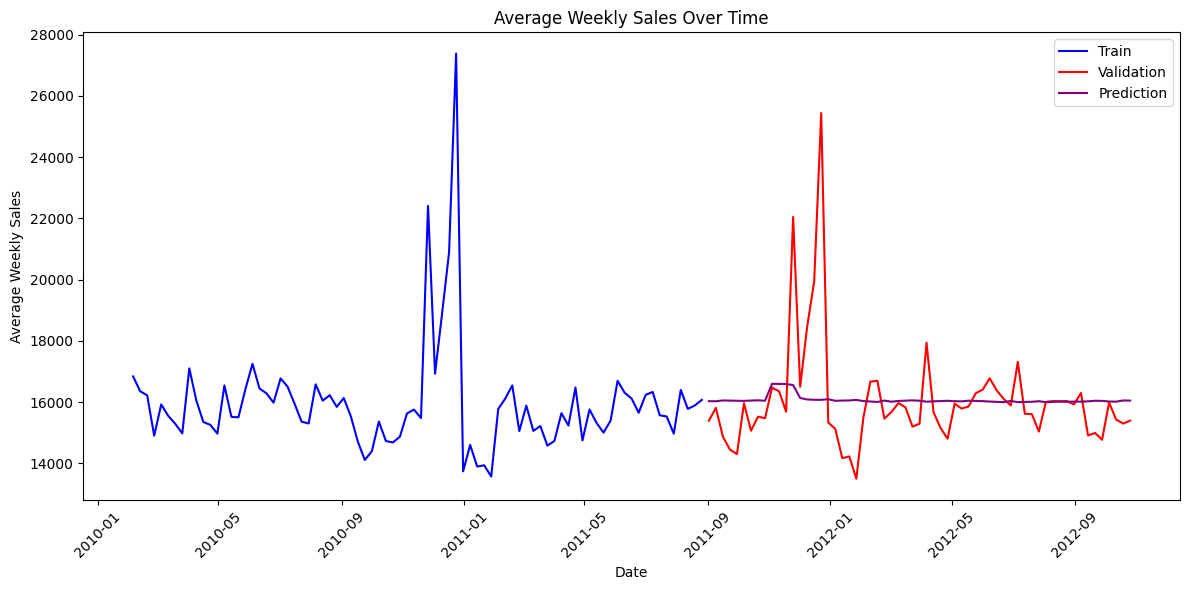

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [18:21:11] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 18:21:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_SquaredError_Estimator_1 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/d29087623d09491db75fdcc53adf4d80
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model1)

## Experiment 2

In [ ]:
class Model2(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_SquaredError_Estimator_10",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 10,
    }

In [ ]:
model2 = Model2(preprocessor_factory=preprocessor_factory1)
model2.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 10}
[0]	train-mae:12099.41442	train-wmae:12099.41406	test-mae:12441.13561	test-wmae:12441.13477
[1]	train-mae:10088.84035	train-wmae:10088.83691	test-mae:10427.93009	test-wmae:10427.93066
[2]	train-mae:9039.72091	train-wmae:9039.72070	test-mae:9361.19315	test-wmae:9361.19238
[3]	train-mae:8291.39645	train-wmae:8291.39648	test-mae:8605.41074	test-wmae:8605.41016
[4]	train-mae:7592.52638	train-wmae:7592.52686	test-mae:7868.85911	test-wmae:7868.85938
[5]	train-mae:7033.36069	train-wmae:7033.36035	test-mae:7297.26162	test-wmae:7297.26172
[6]	train-mae:6697.45105	train-wmae:6697.45117	test-mae:6955.95090	test-wmae:6955.95020
[7]	train-mae:6305.78547	train-wmae:6305.78467	test-mae:6586.02921	test-wmae:6586.02930
[8]	train-mae:6060.30066	train-wmae:6060.30029	test-mae:6351.16099	test-wmae:6351.16260
[9]	train-mae:5879.55288	train-wmae:5879.55273	test-mae:6212.39136	test-wmae:6212.39062

Model Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 10}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 5764.782735066285, 'mae_test': 6036.0493256207, 'wmae_train': np.float64(5879.552881854245), 'wmae_test': np.float64(6212.391364160469)}
Model Data {'run_name': 'XGBoost_Obj_SquaredError_Estimator_10', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


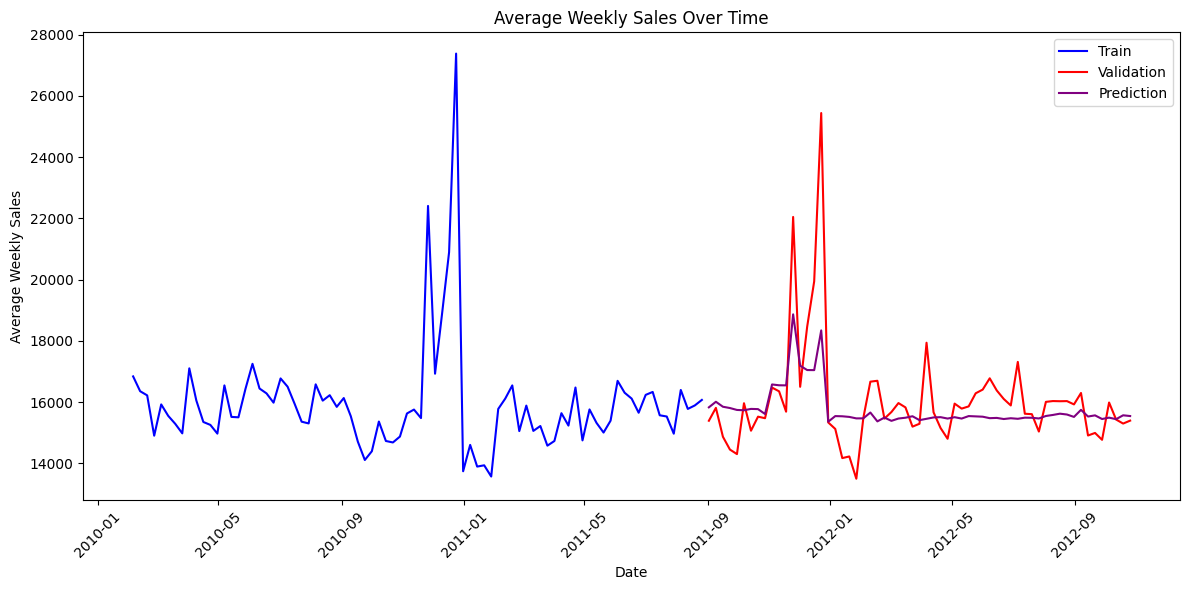

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [18:24:10] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 18:24:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_SquaredError_Estimator_10 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/ba79638ed44f47378550e16da9c20bc6
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model2)

## Experiment 3

In [ ]:
class Model3(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_SquaredError_Estimator_50",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 50,
    }

In [ ]:
model3 = Model3(preprocessor_factory=preprocessor_factory1)
model3.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 50}
[0]	train-mae:12099.41442	train-wmae:12099.41406	test-mae:12441.13561	test-wmae:12441.13477
[1]	train-mae:10088.84035	train-wmae:10088.83691	test-mae:10427.93009	test-wmae:10427.93066
[2]	train-mae:9039.72091	train-wmae:9039.72070	test-mae:9361.19315	test-wmae:9361.19238
[3]	train-mae:8291.39645	train-wmae:8291.39648	test-mae:8605.41074	test-wmae:8605.41016
[4]	train-mae:7592.52638	train-wmae:7592.52686	test-mae:7868.85911	test-wmae:7868.85938
[5]	train-mae:7033.36069	train-wmae:7033.36035	test-mae:7297.26162	test-wmae:7297.26172
[6]	train-mae:6697.45105	train-wmae:6697.45117	test-mae:6955.95090	test-wmae:6955.95020
[7]	train-mae:6305.78547	train-wmae:6305.78467	test-mae:6586.02921	test-wmae:6586.02930
[8]	train-mae:6060.30066	train-wmae:6060.30029	test-mae:6351.16099	test-wmae:6351.16260
[9]	train-mae:5879.55288	train-wmae:5879.55273	test-mae:6212.39136	test-wmae:6212.39062

Model Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 50}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 3459.664740232108, 'mae_test': 3965.1957558024737, 'wmae_train': np.float64(3543.304080702551), 'wmae_test': np.float64(4149.590688103082)}
Model Data {'run_name': 'XGBoost_Obj_SquaredError_Estimator_50', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


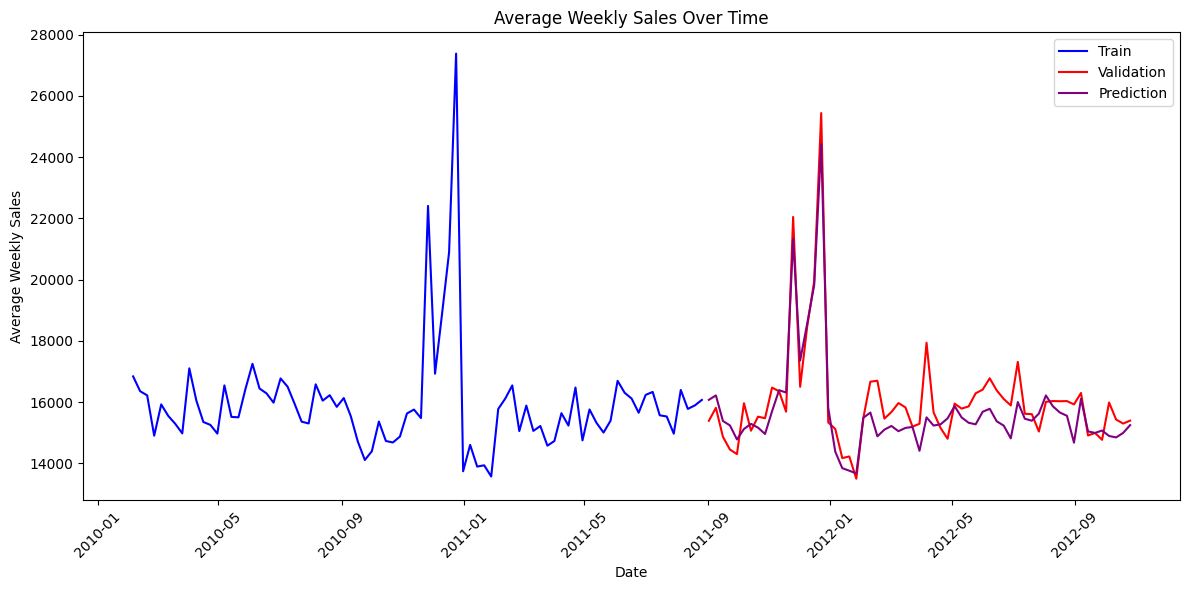

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [18:28:10] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 18:28:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_SquaredError_Estimator_50 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/83b2c6a79c104a04a4282762b7844768
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model3)

## Experiment 4

In [ ]:
class Model4(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_SquaredError_Estimator_100",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 100,
    }

In [ ]:
model4 = Model4(preprocessor_factory=preprocessor_factory1)
model4.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 100}
[0]	train-mae:12099.41442	train-wmae:12099.41406	test-mae:12441.13561	test-wmae:12441.13477
[1]	train-mae:10088.84035	train-wmae:10088.83691	test-mae:10427.93009	test-wmae:10427.93066
[2]	train-mae:9039.72091	train-wmae:9039.72070	test-mae:9361.19315	test-wmae:9361.19238
[3]	train-mae:8291.39645	train-wmae:8291.39648	test-mae:8605.41074	test-wmae:8605.41016
[4]	train-mae:7592.52638	train-wmae:7592.52686	test-mae:7868.85911	test-wmae:7868.85938
[5]	train-mae:7033.36069	train-wmae:7033.36035	test-mae:7297.26162	test-wmae:7297.26172
[6]	train-mae:6697.45105	train-wmae:6697.45117	test-mae:6955.95090	test-wmae:6955.95020
[7]	train-mae:6305.78547	train-wmae:6305.78467	test-mae:6586.02921	test-wmae:6586.02930
[8]	train-mae:6060.30066	train-wmae:6060.30029	test-mae:6351.16099	test-wmae:6351.16260
[9]	train-mae:5879.55288	train-wmae:5879.55273	test-mae:6212.39136	test-wmae:6212.3906

Model Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 100}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 2836.449533380781, 'mae_test': 3554.092786513485, 'wmae_train': np.float64(2887.015479419683), 'wmae_test': np.float64(3707.861059151612)}
Model Data {'run_name': 'XGBoost_Obj_SquaredError_Estimator_100', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


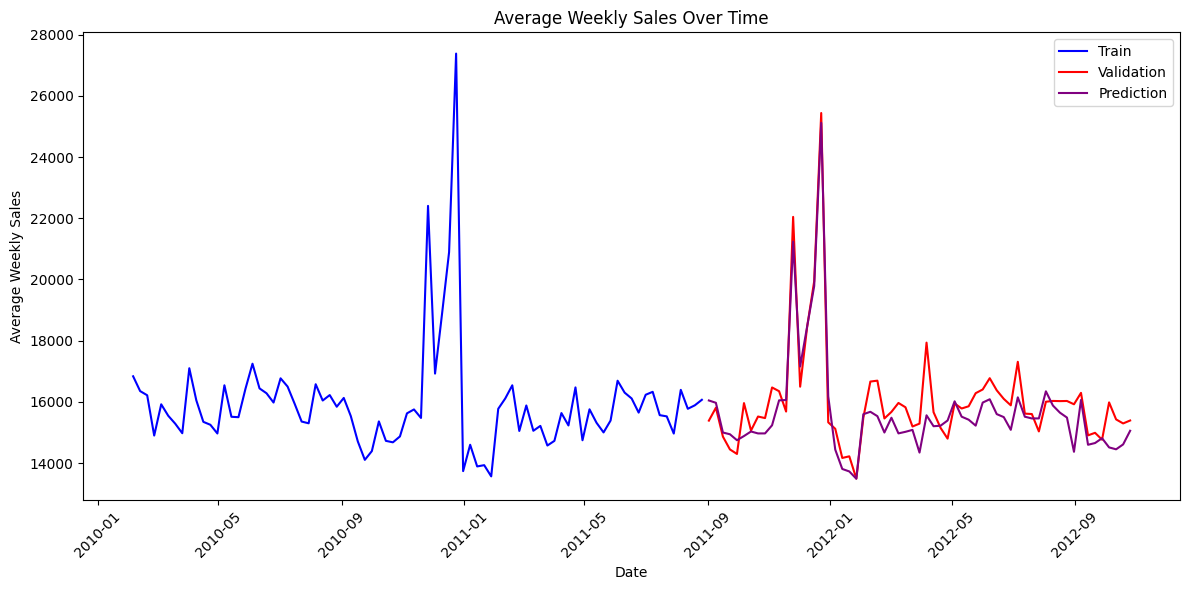

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [19:16:36] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 19:16:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_SquaredError_Estimator_100 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/0880a1c4d07a403088316c552b04b464
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model4)

## Experiment 5

In [ ]:
class Model5(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_SquaredError_Estimator_200",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 200,
    }

In [ ]:
model5 = Model5(preprocessor_factory=preprocessor_factory1)
model5.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 200}
[0]	train-mae:12099.41442	train-wmae:12099.41406	test-mae:12441.13561	test-wmae:12441.13477
[1]	train-mae:10088.84035	train-wmae:10088.83691	test-mae:10427.93009	test-wmae:10427.93066
[2]	train-mae:9039.72091	train-wmae:9039.72070	test-mae:9361.19315	test-wmae:9361.19238
[3]	train-mae:8291.39645	train-wmae:8291.39648	test-mae:8605.41074	test-wmae:8605.41016
[4]	train-mae:7592.52638	train-wmae:7592.52686	test-mae:7868.85911	test-wmae:7868.85938
[5]	train-mae:7033.36069	train-wmae:7033.36035	test-mae:7297.26162	test-wmae:7297.26172
[6]	train-mae:6697.45105	train-wmae:6697.45117	test-mae:6955.95090	test-wmae:6955.95020
[7]	train-mae:6305.78547	train-wmae:6305.78467	test-mae:6586.02921	test-wmae:6586.02930
[8]	train-mae:6060.30066	train-wmae:6060.30029	test-mae:6351.16099	test-wmae:6351.16260
[9]	train-mae:5879.55288	train-wmae:5879.55273	test-mae:6212.39136	test-wmae:6212.3906

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

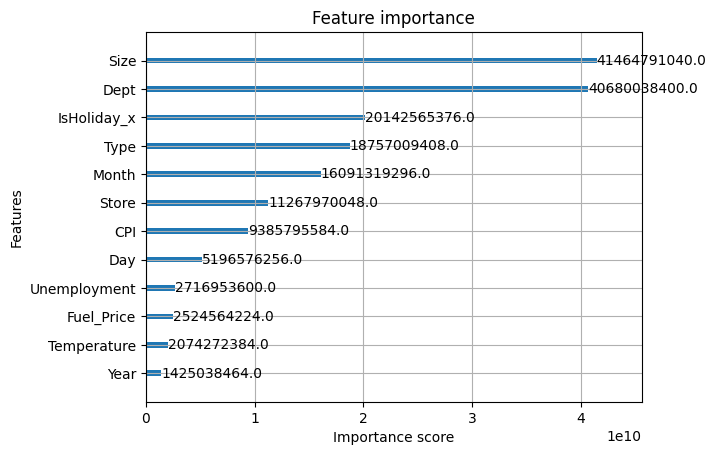

In [ ]:
xgb.plot_importance(model5.model, importance_type='gain')

Model Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae'}, 'num_boost_round': 200}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 2333.30269210183, 'mae_test': 3369.795934797164, 'wmae_train': np.float64(2350.272432798231), 'wmae_test': np.float64(3505.5818113659448)}
Model Data {'run_name': 'XGBoost_Obj_SquaredError_Estimator_200', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


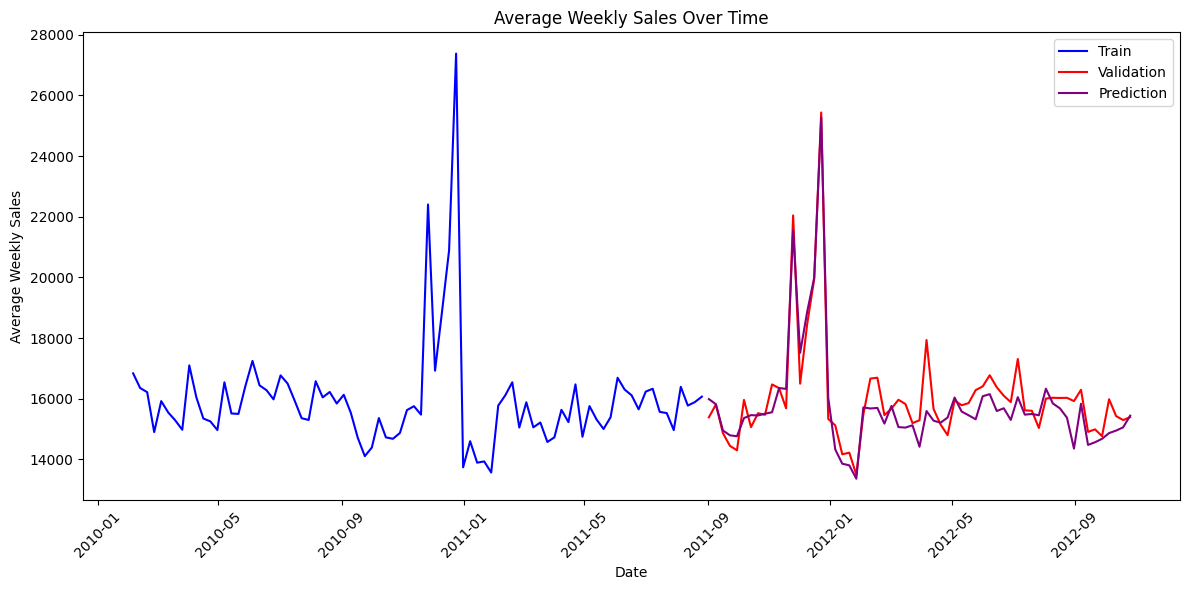

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [19:18:28] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 19:18:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_SquaredError_Estimator_200 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/38aa486a228144f2a599cb6d30700c2a
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model5)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


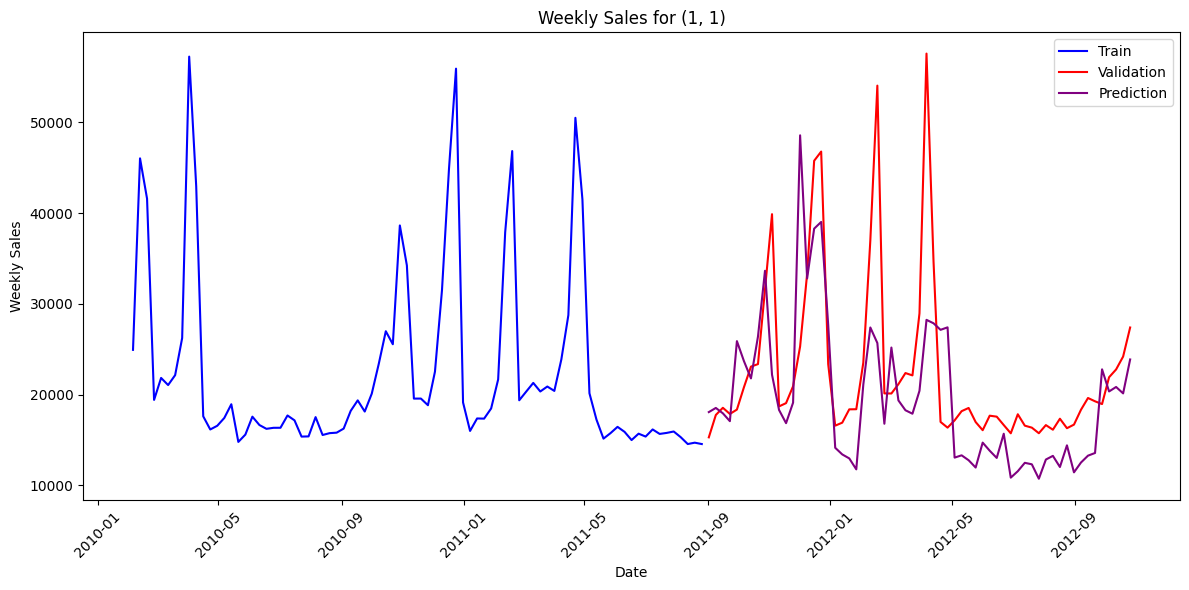

In [ ]:
plot_store_dept(model5, 1, 1)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


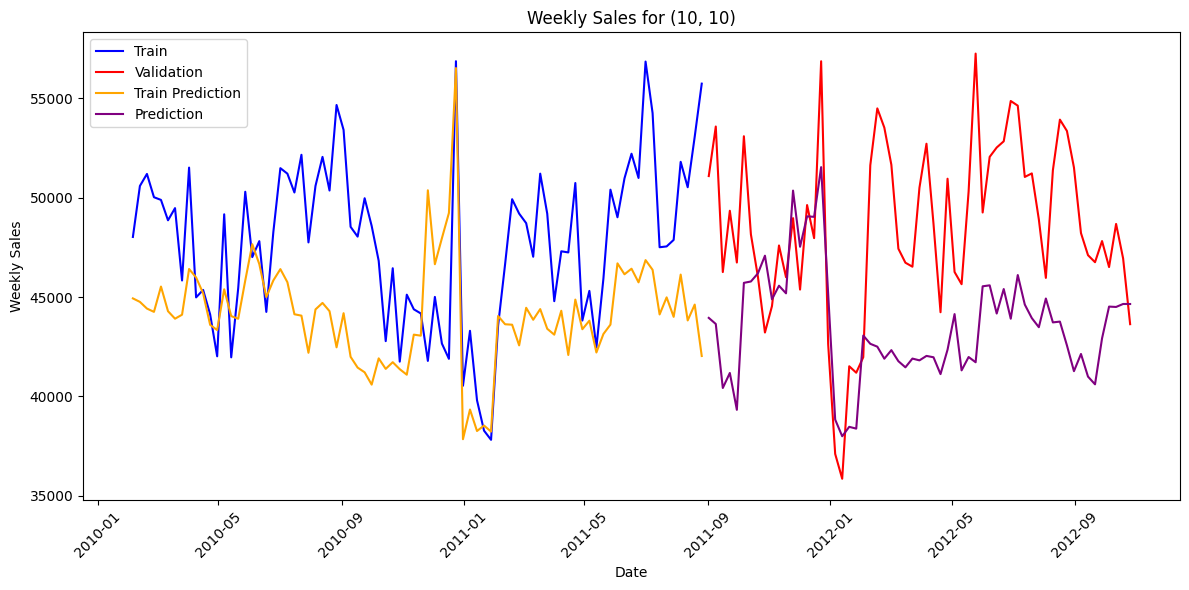

In [ ]:
plot_store_dept(model5, 10, 10)

## Experiment 6

In [ ]:
class Model6(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_AbsoluteError_Estimator_1",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 1,
    }

In [ ]:
model6 = Model6(preprocessor_factory=preprocessor_factory1)
model6.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae'}, 'num_boost_round': 1}
[0]	train-mae:11248.18664	train-wmae:11248.18848	test-mae:11582.63117	test-wmae:11582.63184


Model Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae'}, 'num_boost_round': 1}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 11075.31378309588, 'mae_test': 11305.03717124261, 'wmae_train': np.float64(11248.186628292535), 'wmae_test': np.float64(11582.631160385079)}
Model Data {'run_name': 'XGBoost_Obj_AbsoluteError_Estimator_1', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


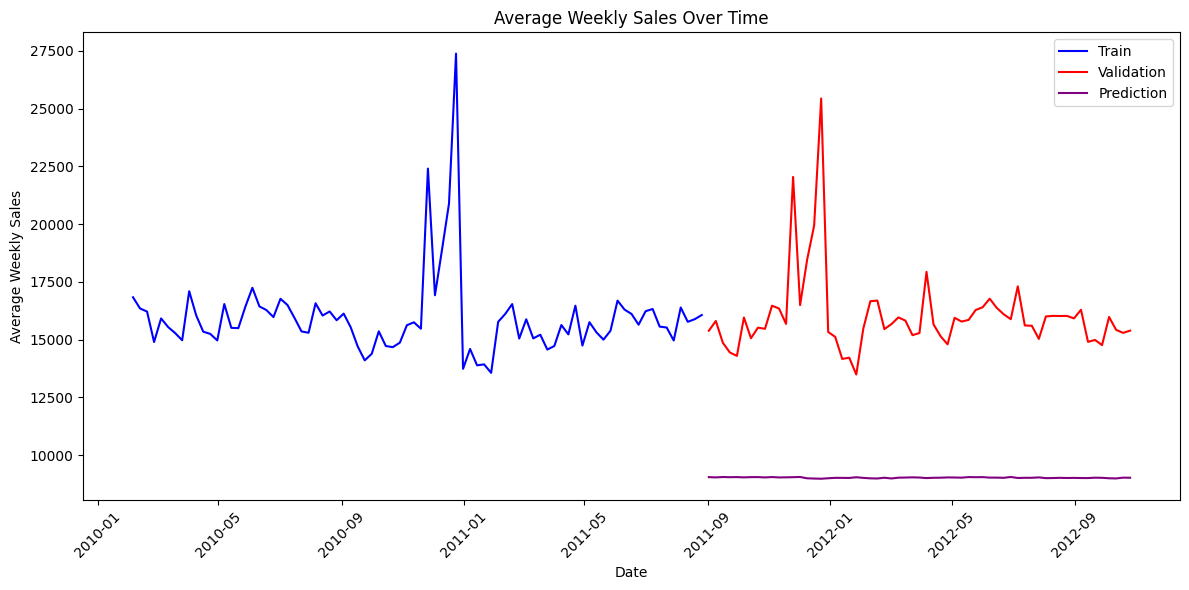

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [19:33:06] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 19:33:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_AbsoluteError_Estimator_1 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/c7f9a37a6b5c49b291cf8453f15cf288
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model6)

In [ ]:
class Model7(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_AbsoluteError_Estimator_50",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 50,
    }

In [ ]:
model7 = Model7(preprocessor_factory=preprocessor_factory1)
model7.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae'}, 'num_boost_round': 50}
[0]	train-mae:11248.18664	train-wmae:11248.18848	test-mae:11582.63117	test-wmae:11582.63184
[1]	train-mae:9668.42023	train-wmae:9668.41992	test-mae:10002.26337	test-wmae:10002.26269
[2]	train-mae:8826.74405	train-wmae:8826.74414	test-mae:9139.94716	test-wmae:9139.94727
[3]	train-mae:8308.49614	train-wmae:8308.49512	test-mae:8652.62017	test-wmae:8652.62012
[4]	train-mae:7837.62829	train-wmae:7837.62842	test-mae:8191.46013	test-wmae:8191.45996
[5]	train-mae:7546.92879	train-wmae:7546.92822	test-mae:7938.18278	test-wmae:7938.18164
[6]	train-mae:7275.94429	train-wmae:7275.94434	test-mae:7691.96843	test-wmae:7691.96777
[7]	train-mae:6978.79288	train-wmae:6978.79297	test-mae:7392.49917	test-wmae:7392.50000
[8]	train-mae:6698.64220	train-wmae:6698.64160	test-mae:7107.34162	test-wmae:7107.34082
[9]	train-mae:6486.85372	train-wmae:6486.85352	test-mae:6912.77441	test-wmae:6912.77441


Model Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae'}, 'num_boost_round': 50}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 3972.1484213578105, 'mae_test': 4487.6070995681275, 'wmae_train': np.float64(4134.530151673101), 'wmae_test': np.float64(4738.96125754854)}
Model Data {'run_name': 'XGBoost_Obj_AbsoluteError_Estimator_50', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


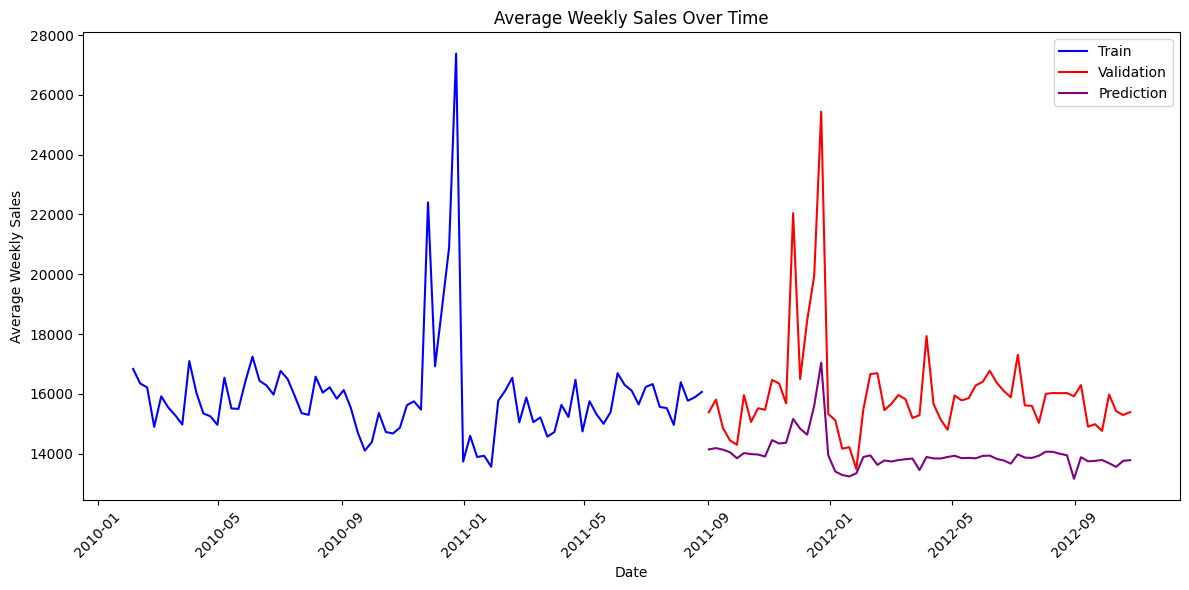

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [19:34:58] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 19:35:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_AbsoluteError_Estimator_50 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/169eac1a83d241e0bf35f99b69796c63
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model7)

In [ ]:
class Model8(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_AbsoluteError_Estimator_100",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 100,
    }

In [ ]:
model8 = Model8(preprocessor_factory=preprocessor_factory1)
model8.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae'}, 'num_boost_round': 100}
[0]	train-mae:11248.18664	train-wmae:11248.18848	test-mae:11582.63117	test-wmae:11582.63184
[1]	train-mae:9668.42023	train-wmae:9668.41992	test-mae:10002.26337	test-wmae:10002.26269
[2]	train-mae:8826.74405	train-wmae:8826.74414	test-mae:9139.94716	test-wmae:9139.94727
[3]	train-mae:8308.49614	train-wmae:8308.49512	test-mae:8652.62017	test-wmae:8652.62012
[4]	train-mae:7837.62829	train-wmae:7837.62842	test-mae:8191.46013	test-wmae:8191.45996
[5]	train-mae:7546.92879	train-wmae:7546.92822	test-mae:7938.18278	test-wmae:7938.18164
[6]	train-mae:7275.94429	train-wmae:7275.94434	test-mae:7691.96843	test-wmae:7691.96777
[7]	train-mae:6978.79288	train-wmae:6978.79297	test-mae:7392.49917	test-wmae:7392.50000
[8]	train-mae:6698.64220	train-wmae:6698.64160	test-mae:7107.34162	test-wmae:7107.34082
[9]	train-mae:6486.85372	train-wmae:6486.85352	test-mae:6912.77441	test-wmae:6912.77441

Model Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae'}, 'num_boost_round': 100}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 3251.7926921423286, 'mae_test': 3882.6473825704697, 'wmae_train': np.float64(3393.5045087223466), 'wmae_test': np.float64(4106.367590955688)}
Model Data {'run_name': 'XGBoost_Obj_AbsoluteError_Estimator_100', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


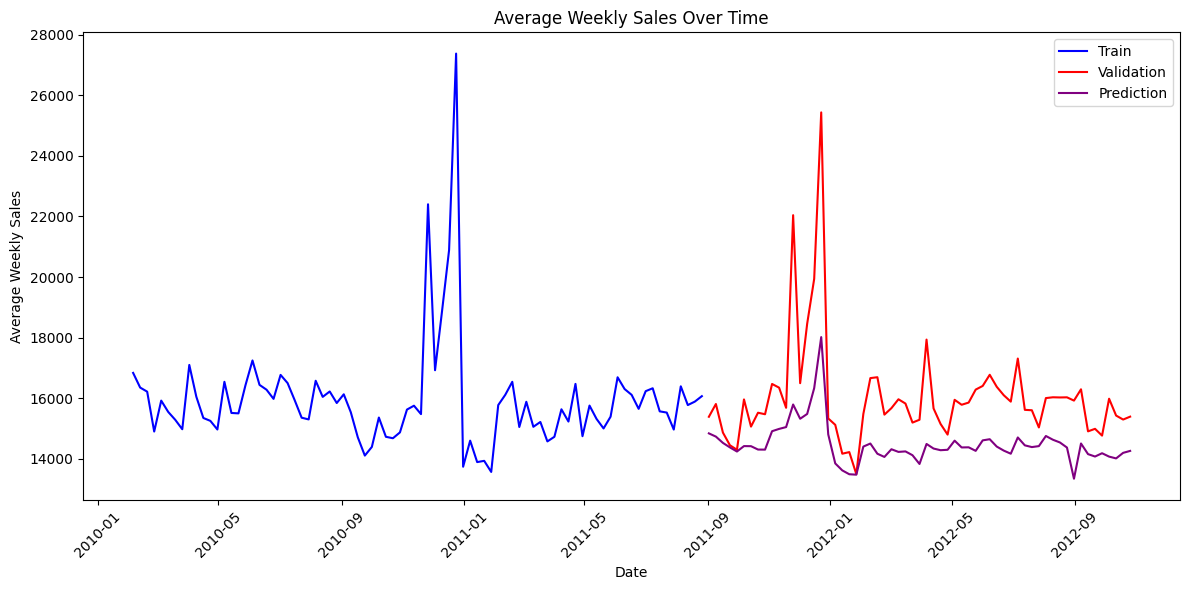

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [19:37:00] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 19:37:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_AbsoluteError_Estimator_100 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/7a0bcf1ed1af49b6bdf35628bc86b50f
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model8)

In [ ]:
class Model9(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_AbsoluteError_Estimator_100_HigherLR",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
        'eta': 0.2,
      },
      'num_boost_round': 100,
    }

In [ ]:
model9 = Model9(preprocessor_factory=preprocessor_factory1)
model9.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'eta': 0.2}, 'num_boost_round': 100}
[0]	train-mae:11943.33861	train-wmae:11943.33691	test-mae:12281.44622	test-wmae:12281.44824
[1]	train-mae:10861.96503	train-wmae:10861.96484	test-mae:11198.86550	test-wmae:11198.86523
[2]	train-mae:10077.85070	train-wmae:10077.85156	test-mae:10415.88593	test-wmae:10415.88574
[3]	train-mae:9245.93387	train-wmae:9245.93359	test-mae:9603.25886	test-wmae:9603.25879
[4]	train-mae:8854.90155	train-wmae:8854.90039	test-mae:9219.30543	test-wmae:9219.30566
[5]	train-mae:8526.11332	train-wmae:8526.11328	test-mae:8896.27473	test-wmae:8896.27441
[6]	train-mae:8227.56597	train-wmae:8227.56641	test-mae:8599.34722	test-wmae:8599.34668
[7]	train-mae:7957.71311	train-wmae:7957.71191	test-mae:8322.36890	test-wmae:8322.36816
[8]	train-mae:7823.08001	train-wmae:7823.07910	test-mae:8191.88771	test-wmae:8191.88867
[9]	train-mae:7615.55702	train-wmae:7615.55615	test-mae:7989.59811	te

Model Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'eta': 0.2}, 'num_boost_round': 100}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 3501.5863772570683, 'mae_test': 3982.4765484551144, 'wmae_train': np.float64(3649.768545723227), 'wmae_test': np.float64(4218.194824268481)}
Model Data {'run_name': 'XGBoost_Obj_AbsoluteError_Estimator_100_HigherLR', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


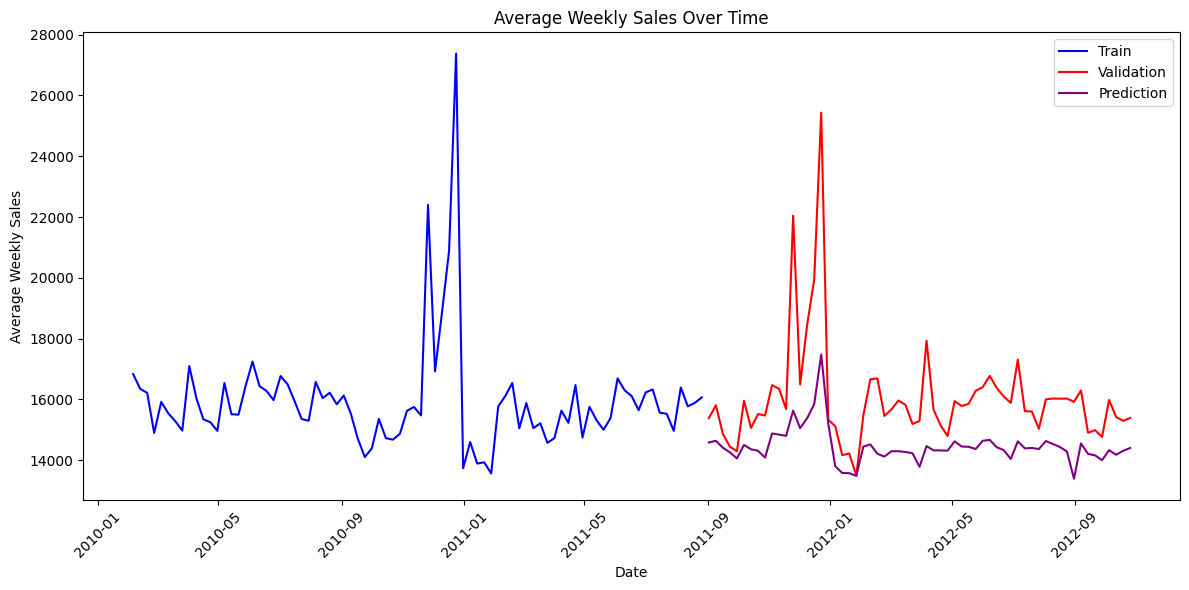

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [19:41:40] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/04 19:41:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_AbsoluteError_Estimator_100_HigherLR at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/d647f1d8883a4bc59f2690cdb365c670
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model9)

## Experiment 10

In [ ]:
class Model10(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_AbsoluteError_Estimator_200_HigherLR",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
        'eta': 0.2,
      },
      'num_boost_round': 200,
    }

In [ ]:
model10 = Model10(preprocessor_factory=preprocessor_factory1)
model10.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'eta': 0.2}, 'num_boost_round': 200}
[0]	train-mae:11943.33861	train-wmae:11943.33691	test-mae:12281.44622	test-wmae:12281.44824
[1]	train-mae:10861.96503	train-wmae:10861.96484	test-mae:11198.86550	test-wmae:11198.86523
[2]	train-mae:10077.85070	train-wmae:10077.85156	test-mae:10415.88593	test-wmae:10415.88574
[3]	train-mae:9245.93387	train-wmae:9245.93359	test-mae:9603.25886	test-wmae:9603.25879
[4]	train-mae:8854.90155	train-wmae:8854.90039	test-mae:9219.30543	test-wmae:9219.30566
[5]	train-mae:8526.11332	train-wmae:8526.11328	test-mae:8896.27473	test-wmae:8896.27441
[6]	train-mae:8227.56597	train-wmae:8227.56641	test-mae:8599.34722	test-wmae:8599.34668
[7]	train-mae:7957.71311	train-wmae:7957.71191	test-mae:8322.36890	test-wmae:8322.36816
[8]	train-mae:7823.08001	train-wmae:7823.07910	test-mae:8191.88771	test-wmae:8191.88867
[9]	train-mae:7615.55702	train-wmae:7615.55615	test-mae:7989.59811	te

Model Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'eta': 0.2}, 'num_boost_round': 200}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 2956.6041536645034, 'mae_test': 3603.8863546155676, 'wmae_train': np.float64(3087.312786586592), 'wmae_test': np.float64(3824.558317655287)}
Model Data {'run_name': 'XGBoost_Obj_AbsoluteError_Estimator_200_HigherLR', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


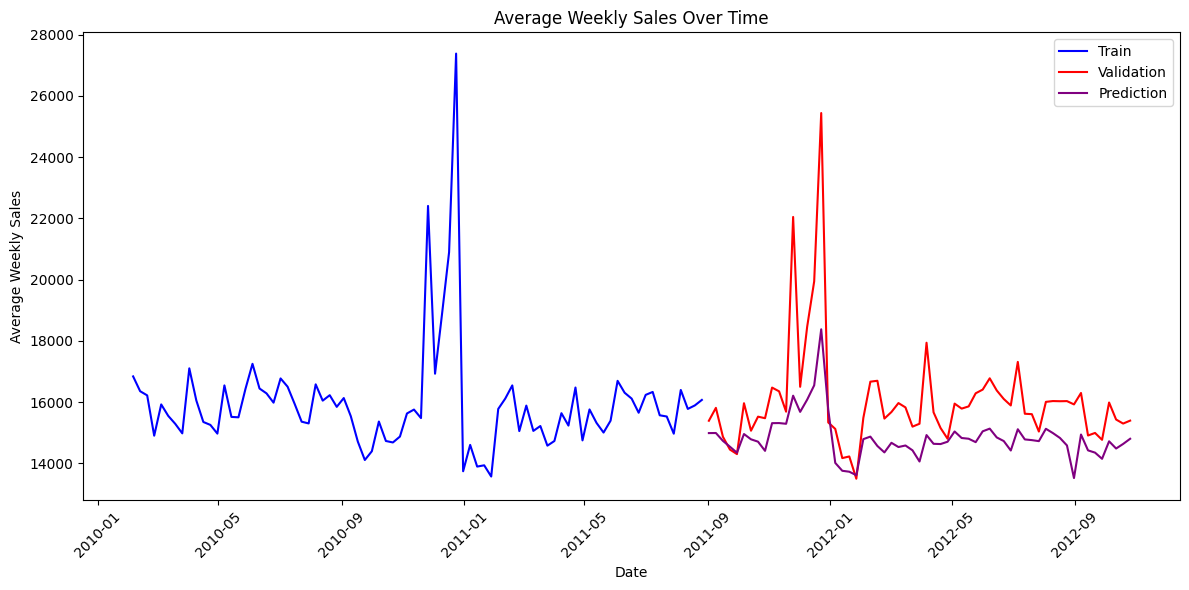

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [11:32:59] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/05 11:33:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_AbsoluteError_Estimator_200_HigherLR at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/013e2ffe085847bca641b2f370a7ccd9
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model10)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


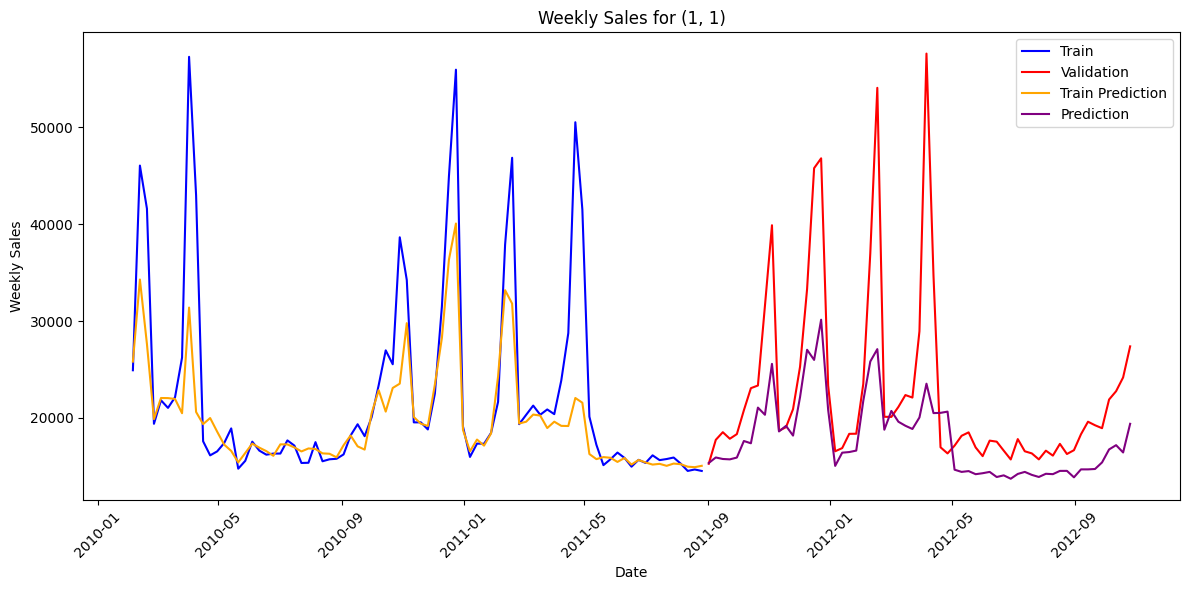

In [ ]:
plot_store_dept(model10, 1, 1)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


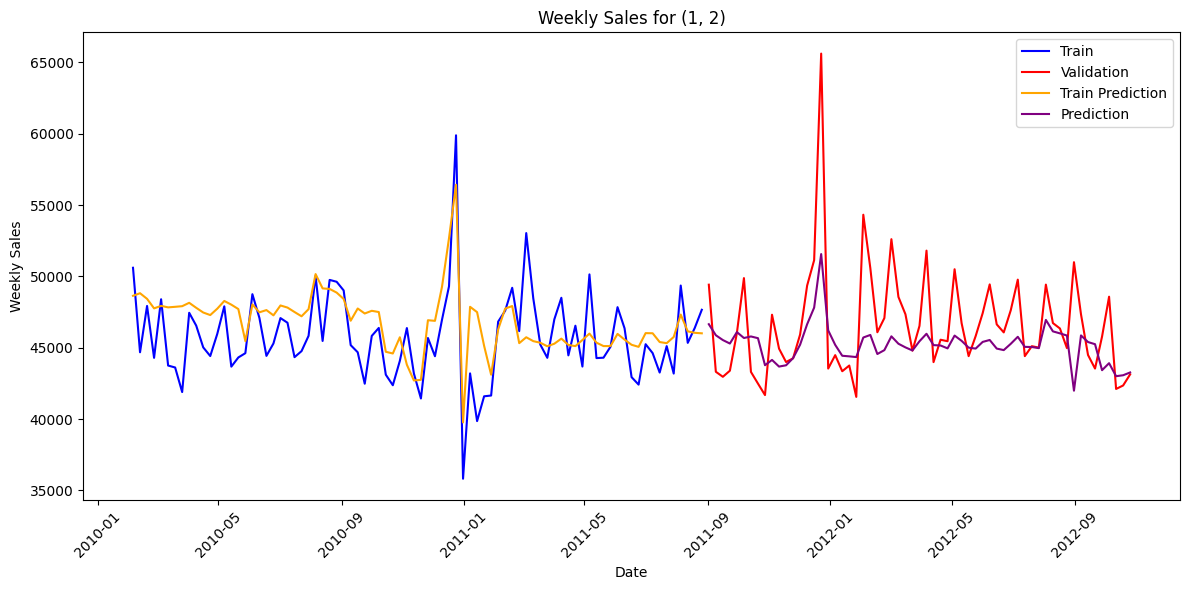

In [ ]:
plot_store_dept(model10, 1, 2)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


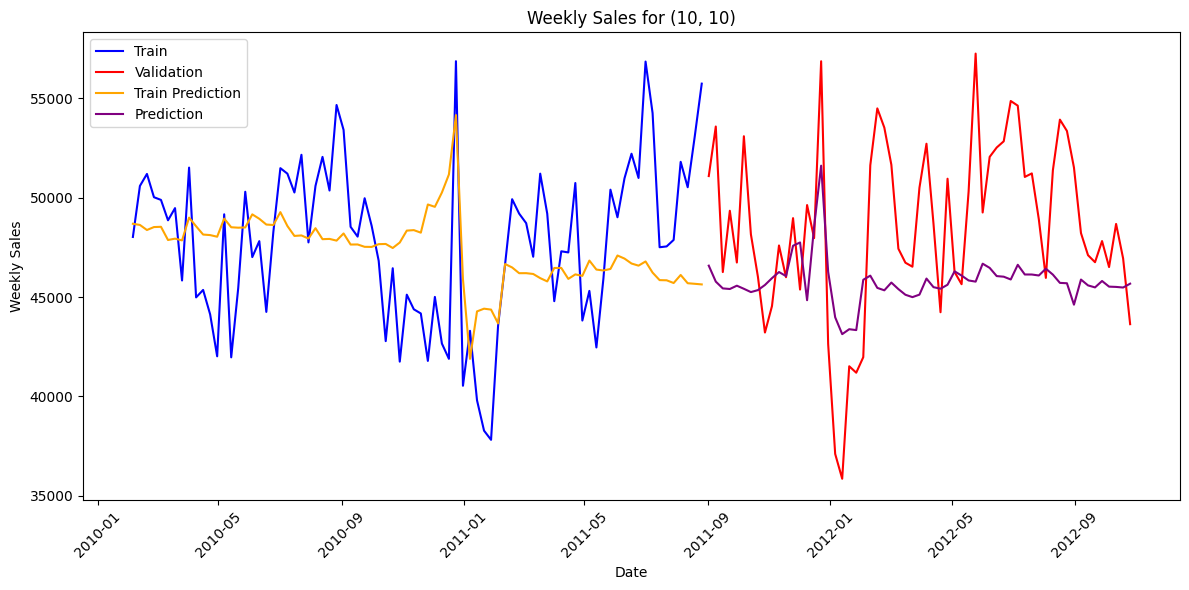

In [ ]:
plot_store_dept(model10, 10, 10)

## Experiment 11

In [ ]:
class Model11(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_HuberError_Estimator_100",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:pseudohubererror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 100,
    }

In [ ]:
model11 = Model11(preprocessor_factory=preprocessor_factory1)
model11.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae'}, 'num_boost_round': 100}
[0]	train-mae:12693.92110	train-wmae:12693.92188	test-mae:13128.05911	test-wmae:13128.05762
[1]	train-mae:11980.70349	train-wmae:11980.70508	test-mae:12321.98083	test-wmae:12321.98242
[2]	train-mae:11577.08114	train-wmae:11577.08203	test-mae:11930.82606	test-wmae:11930.82519
[3]	train-mae:11458.59826	train-wmae:11458.59863	test-mae:11814.84415	test-wmae:11814.84473
[4]	train-mae:11254.08276	train-wmae:11254.08203	test-mae:11597.49229	test-wmae:11597.49316
[5]	train-mae:11120.30221	train-wmae:11120.30371	test-mae:11462.33707	test-wmae:11462.33691
[6]	train-mae:11003.30336	train-wmae:11003.30273	test-mae:11355.19767	test-wmae:11355.19629
[7]	train-mae:10916.02816	train-wmae:10916.02734	test-mae:11276.02148	test-wmae:11276.02246
[8]	train-mae:10838.21361	train-wmae:10838.21289	test-mae:11204.32300	test-wmae:11204.32324
[9]	train-mae:10740.31026	train-wmae:10740.31055	test-

Model Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae'}, 'num_boost_round': 100}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 7089.928259939491, 'mae_test': 7496.6135887638, 'wmae_train': np.float64(7258.1903718687), 'wmae_test': np.float64(7751.121990001502)}
Model Data {'run_name': 'XGBoost_Obj_HuberError_Estimator_100', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


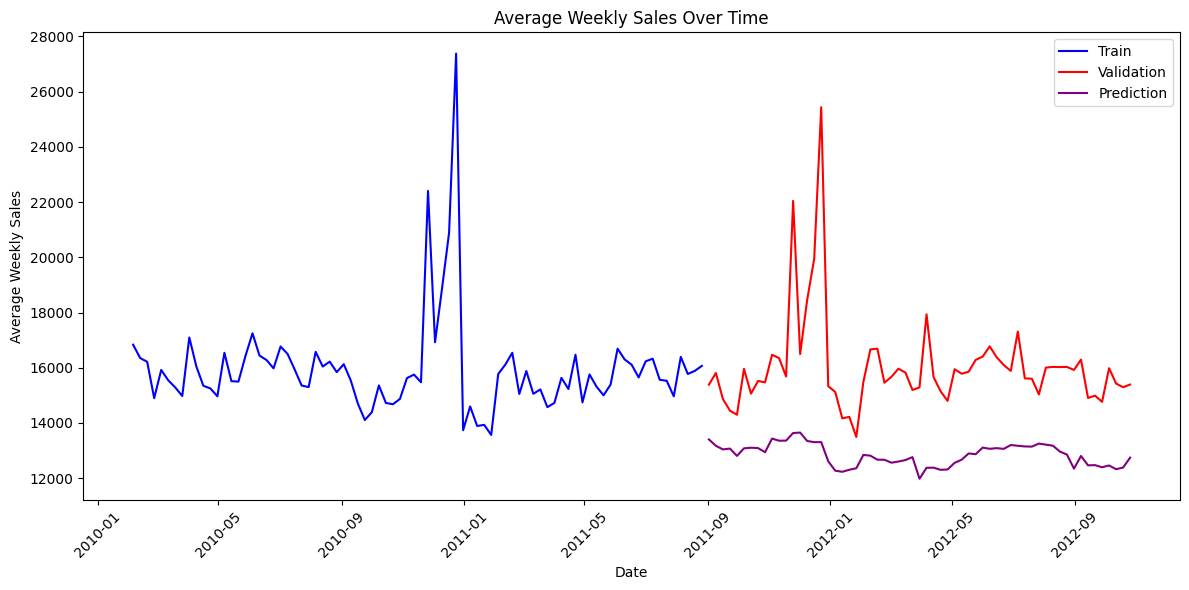

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [11:38:47] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/05 11:38:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_HuberError_Estimator_100 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/884d1229000847a6a51175318fbf76d6
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model11)

## Experiment 12

In [ ]:
class Model12(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_HuberError_Estimator_300",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:pseudohubererror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 300,
    }

In [ ]:
model12 = Model12(preprocessor_factory=preprocessor_factory1)
model12.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae'}, 'num_boost_round': 300}
[0]	train-mae:12693.92110	train-wmae:12693.92188	test-mae:13128.05911	test-wmae:13128.05762
[1]	train-mae:11980.70349	train-wmae:11980.70508	test-mae:12321.98083	test-wmae:12321.98242
[2]	train-mae:11577.08114	train-wmae:11577.08203	test-mae:11930.82606	test-wmae:11930.82519
[3]	train-mae:11458.59826	train-wmae:11458.59863	test-mae:11814.84415	test-wmae:11814.84473
[4]	train-mae:11254.08276	train-wmae:11254.08203	test-mae:11597.49229	test-wmae:11597.49316
[5]	train-mae:11120.30221	train-wmae:11120.30371	test-mae:11462.33707	test-wmae:11462.33691
[6]	train-mae:11003.30336	train-wmae:11003.30273	test-mae:11355.19767	test-wmae:11355.19629
[7]	train-mae:10916.02816	train-wmae:10916.02734	test-mae:11276.02148	test-wmae:11276.02246
[8]	train-mae:10838.21361	train-wmae:10838.21289	test-mae:11204.32300	test-wmae:11204.32324
[9]	train-mae:10740.31026	train-wmae:10740.31055	test-

Model Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae'}, 'num_boost_round': 300}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 5537.680074727412, 'mae_test': 6059.472693378056, 'wmae_train': np.float64(5709.7024961570805), 'wmae_test': np.float64(6310.386459912457)}
Model Data {'run_name': 'XGBoost_Obj_HuberError_Estimator_300', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


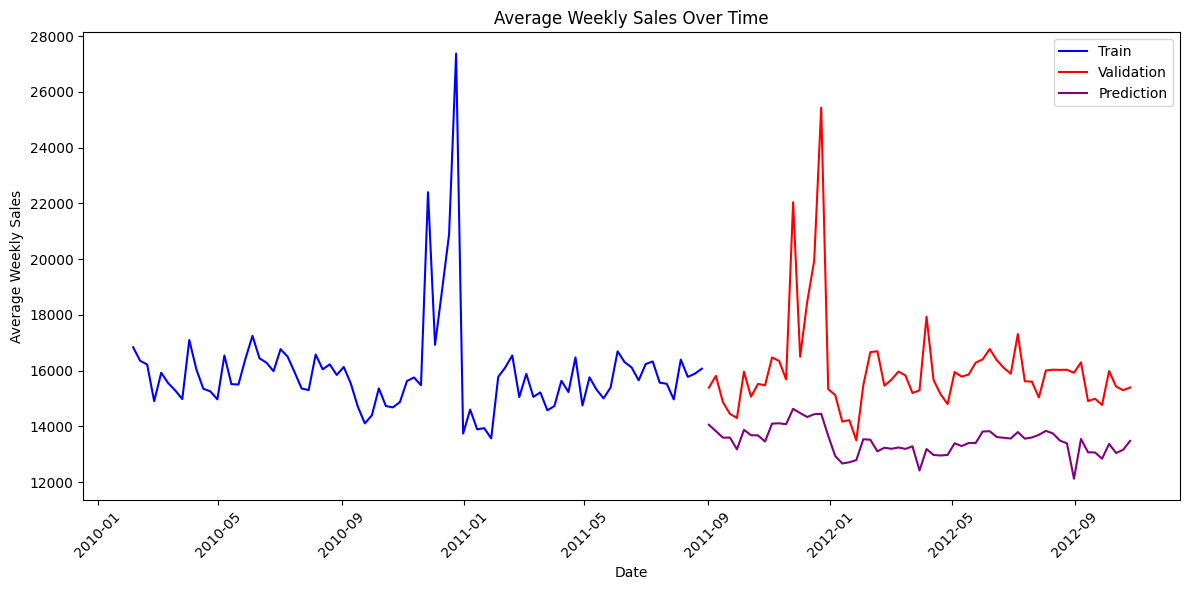

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [11:42:19] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/05 11:42:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_HuberError_Estimator_300 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/8b8839848b5f4a8eaad01ff73ad5dc7a
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model12)

## Experiment 13

In [ ]:
class Model13(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_HuberError_Estimator_300_Slope_05",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:pseudohubererror',
        'eval_metric': 'mae',
        'huber_slope': 0.5,
      },
      'num_boost_round': 300,
    }

In [ ]:
model13 = Model13(preprocessor_factory=preprocessor_factory1)
model13.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 0.5}, 'num_boost_round': 300}
[0]	train-mae:13568.52962	train-wmae:13568.52930	test-mae:13964.15429	test-wmae:13964.15527
[1]	train-mae:12669.88639	train-wmae:12669.88574	test-mae:13067.18400	test-wmae:13067.18262
[2]	train-mae:12221.61089	train-wmae:12221.61133	test-mae:12617.08708	test-wmae:12617.08594
[3]	train-mae:12023.91731	train-wmae:12023.91504	test-mae:12410.95901	test-wmae:12410.95996
[4]	train-mae:11828.40070	train-wmae:11828.40137	test-mae:12205.72379	test-wmae:12205.72363
[5]	train-mae:11665.29996	train-wmae:11665.29981	test-mae:12063.77928	test-wmae:12063.78027
[6]	train-mae:11515.23973	train-wmae:11515.23926	test-mae:11932.94680	test-wmae:11932.94727
[7]	train-mae:11382.61200	train-wmae:11382.61231	test-mae:11807.78843	test-wmae:11807.78711
[8]	train-mae:11291.90116	train-wmae:11291.90137	test-mae:11705.32920	test-wmae:11705.32910
[9]	train-mae:11194.58930	train-wm

Model Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 0.5}, 'num_boost_round': 300}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 6924.995903228182, 'mae_test': 7296.013974908372, 'wmae_train': np.float64(7087.356122668019), 'wmae_test': np.float64(7562.739296835187)}
Model Data {'run_name': 'XGBoost_Obj_HuberError_Estimator_300_Slope_05', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


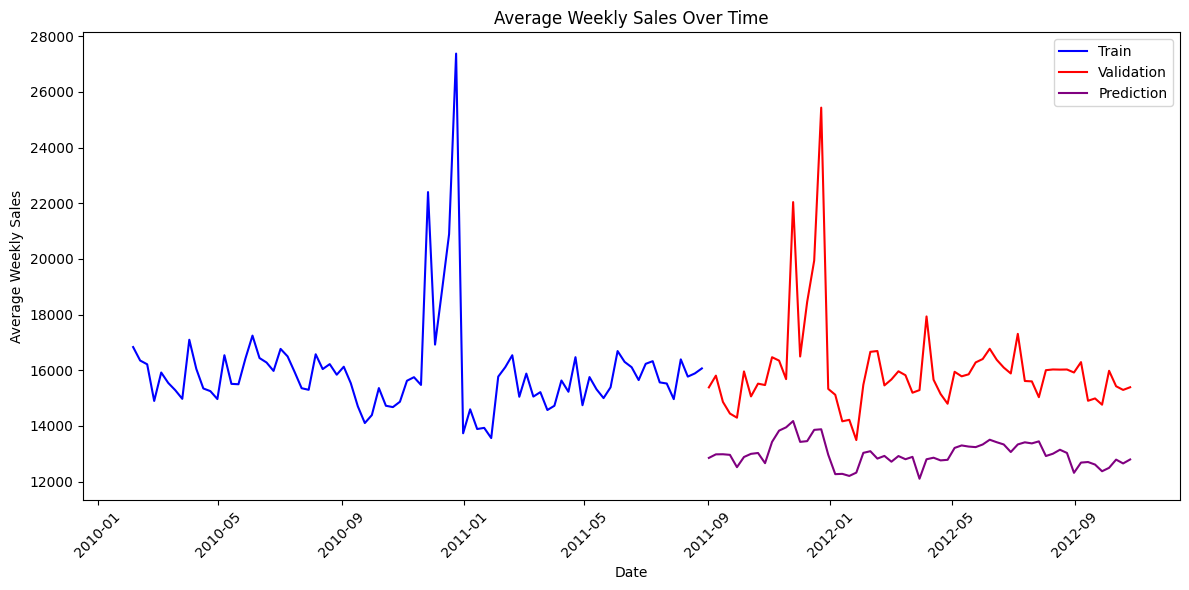

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [11:46:46] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/05 11:46:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_HuberError_Estimator_300_Slope_05 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/db77359bb8af49e4b350a7c8cd8184e9
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model13)

## Experiment 14

In [ ]:
class Model14(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_HuberError_Estimator_100_SlopeSearch",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:pseudohubererror',
        'eval_metric': 'mae',
      },
      'num_boost_round': 100,
    }

In [ ]:
models = []

best_wmae = 999999
best_mode = None

for huber_slope in [0.7, 1.5, 2.5, 5, 10, 100, 1000]:
  model = Model14(preprocessor_factory=preprocessor_factory1)
  model.train_params['params']['huber_slope'] = huber_slope
  model.train(X_train, y_train, X_test, y_test)
  m = model.get_metrics(X_train, y_train, X_test, y_test)
  if m['wmae_test'] < best_wmae:
    best_wmae = m['wmae_test']
    best_model = model
  print(m)
  models.append(model)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 0.7}, 'num_boost_round': 100}
[0]	train-mae:13869.55686	train-wmae:13869.55762	test-mae:14097.88716	test-wmae:14097.88672
[1]	train-mae:13019.11218	train-wmae:13019.11133	test-mae:13375.20750	test-wmae:13375.20703
[2]	train-mae:12181.89659	train-wmae:12181.89746	test-mae:12495.68120	test-wmae:12495.68066
[3]	train-mae:11754.74249	train-wmae:11754.74023	test-mae:12119.66015	test-wmae:12119.65918
[4]	train-mae:11518.67262	train-wmae:11518.67285	test-mae:11889.06683	test-wmae:11889.06641
[5]	train-mae:11320.66835	train-wmae:11320.66894	test-mae:11701.39619	test-wmae:11701.39746
[6]	train-mae:11239.04291	train-wmae:11239.04394	test-mae:11619.46273	test-wmae:11619.46094
[7]	train-mae:11132.76286	train-wmae:11132.76269	test-mae:11517.62216	test-wmae:11517.62109
[8]	train-mae:10998.03045	train-wmae:10998.03027	test-mae:11380.57125	test-wmae:11380.57129
[9]	train-mae:10921.30919	train-wm

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


{'mae_train': 7689.628348176535, 'mae_test': 8057.548294705311, 'wmae_train': np.float64(7852.4924877318335), 'wmae_test': np.float64(8325.069415166965)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 1.5}, 'num_boost_round': 100}
[0]	train-mae:13172.54802	train-wmae:13172.54785	test-mae:13585.78044	test-wmae:13585.78125
[1]	train-mae:12279.45525	train-wmae:12279.45508	test-mae:12695.44646	test-wmae:12695.44727
[2]	train-mae:11571.67105	train-wmae:11571.66992	test-mae:11993.02617	test-wmae:11993.02539
[3]	train-mae:11225.77840	train-wmae:11225.77832	test-mae:11646.77620	test-wmae:11646.77539
[4]	train-mae:10996.39457	train-wmae:10996.39356	test-mae:11442.03276	test-wmae:11442.03320
[5]	train-mae:10873.34648	train-wmae:10873.34766	test-mae:11314.90278	test-wmae:11314.90234
[6]	train-mae:10659.16499	train-wmae:10659.16211	test-mae:11088.15014	test-wmae:11088.14941
[7]	train-mae:10538.34332	train-wmae:10538.34375	test-mae:10959.57687	test-wmae:10959.57910
[8]	train-mae:10448.09101	train-wmae:10448.09180	test-mae:10875.03412	test-wmae:10875.03418
[9]	train-mae:10235.65831	train-wm

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


{'mae_train': 6458.564096192047, 'mae_test': 6858.594571033566, 'wmae_train': np.float64(6635.587708274369), 'wmae_test': np.float64(7128.953342939819)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 2.5}, 'num_boost_round': 100}
[0]	train-mae:13192.61908	train-wmae:13192.62012	test-mae:13466.60967	test-wmae:13466.61133
[1]	train-mae:11622.46270	train-wmae:11622.46191	test-mae:11965.27083	test-wmae:11965.27051
[2]	train-mae:10826.27944	train-wmae:10826.27832	test-mae:11159.95659	test-wmae:11159.95606
[3]	train-mae:10429.59702	train-wmae:10429.59766	test-mae:10779.17424	test-wmae:10779.17578
[4]	train-mae:10134.12424	train-wmae:10134.12305	test-mae:10474.67976	test-wmae:10474.67969
[5]	train-mae:9905.84142	train-wmae:9905.84180	test-mae:10255.89021	test-wmae:10255.89062
[6]	train-mae:9754.63800	train-wmae:9754.63672	test-mae:10135.67231	test-wmae:10135.67383
[7]	train-mae:9516.25944	train-wmae:9516.25977	test-mae:9931.44697	test-wmae:9931.44824
[8]	train-mae:9442.23727	train-wmae:9442.23828	test-mae:9850.11162	test-wmae:9850.11231
[9]	train-mae:9335.63822	train-wmae:9335.63769

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


{'mae_train': 5882.77300255562, 'mae_test': 6316.515279265638, 'wmae_train': np.float64(6057.040704002829), 'wmae_test': np.float64(6581.807476272327)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 5}, 'num_boost_round': 100}
[0]	train-mae:13304.67408	train-wmae:13304.67383	test-mae:13669.20370	test-wmae:13669.20508
[1]	train-mae:11171.17894	train-wmae:11171.17773	test-mae:11850.84302	test-wmae:11850.84473
[2]	train-mae:10546.56392	train-wmae:10546.56543	test-mae:11229.34635	test-wmae:11229.34863
[3]	train-mae:10245.56031	train-wmae:10245.56152	test-mae:10932.02477	test-wmae:10932.02148
[4]	train-mae:10127.49760	train-wmae:10127.49805	test-mae:10840.04463	test-wmae:10840.04394
[5]	train-mae:9895.69342	train-wmae:9895.69238	test-mae:10609.86936	test-wmae:10609.87012
[6]	train-mae:9579.95997	train-wmae:9579.96094	test-mae:10284.07935	test-wmae:10284.07812
[7]	train-mae:9483.82719	train-wmae:9483.82617	test-mae:10170.58800	test-wmae:10170.58887
[8]	train-mae:9369.71260	train-wmae:9369.71191	test-mae:10049.33611	test-wmae:10049.33691
[9]	train-mae:9164.82155	train-wmae:9164.821

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


{'mae_train': 5002.081243972748, 'mae_test': 5871.577869836451, 'wmae_train': np.float64(5161.677213217789), 'wmae_test': np.float64(6081.8677456315645)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 10}, 'num_boost_round': 100}
[0]	train-mae:13498.70787	train-wmae:13498.70703	test-mae:13523.20065	test-wmae:13523.20019
[1]	train-mae:11864.32113	train-wmae:11864.32031	test-mae:12308.70286	test-wmae:12308.70215
[2]	train-mae:11209.58946	train-wmae:11209.59082	test-mae:11828.24439	test-wmae:11828.24414
[3]	train-mae:10631.16955	train-wmae:10631.16992	test-mae:11475.57248	test-wmae:11475.57227
[4]	train-mae:10313.17941	train-wmae:10313.17969	test-mae:11356.84174	test-wmae:11356.84277
[5]	train-mae:10075.72760	train-wmae:10075.72754	test-mae:11130.59460	test-wmae:11130.59473
[6]	train-mae:9667.15892	train-wmae:9667.15820	test-mae:10802.43191	test-wmae:10802.43164
[7]	train-mae:9524.28552	train-wmae:9524.28613	test-mae:10650.69582	test-wmae:10650.69629
[8]	train-mae:9422.30408	train-wmae:9422.30371	test-mae:10544.61803	test-wmae:10544.62012
[9]	train-mae:9296.84245	train-wmae:9296.

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


{'mae_train': 4590.3573569983255, 'mae_test': 5370.413544734716, 'wmae_train': np.float64(4752.668478419167), 'wmae_test': np.float64(5623.664094910361)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 100}, 'num_boost_round': 100}
[0]	train-mae:25271.59059	train-wmae:25271.58984	test-mae:24135.40311	test-wmae:24135.40234
[1]	train-mae:17431.55176	train-wmae:17431.54883	test-mae:15662.97626	test-wmae:15662.97559
[2]	train-mae:20283.18810	train-wmae:20283.18750	test-mae:19144.29090	test-wmae:19144.29102
[3]	train-mae:15531.09834	train-wmae:15531.09961	test-mae:14951.22959	test-wmae:14951.23144
[4]	train-mae:17645.38358	train-wmae:17645.38477	test-mae:16553.51218	test-wmae:16553.51172
[5]	train-mae:16249.14404	train-wmae:16249.14453	test-mae:15807.52100	test-wmae:15807.52148
[6]	train-mae:14826.23571	train-wmae:14826.23633	test-mae:13916.84674	test-wmae:13916.84766
[7]	train-mae:14505.61844	train-wmae:14505.61816	test-mae:13601.02911	test-wmae:13601.02930
[8]	train-mae:14859.25815	train-wmae:14859.25684	test-mae:13628.18170	test-wmae:13628.17969
[9]	train-mae:14320.07788	train-wm

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


{'mae_train': 6710.205838394586, 'mae_test': 7566.794470757254, 'wmae_train': np.float64(6895.156676844268), 'wmae_test': np.float64(7749.643094428514)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 1000}, 'num_boost_round': 100}
[0]	train-mae:51805.51345	train-wmae:51805.51562	test-mae:51228.26421	test-wmae:51228.26172
[1]	train-mae:67280.77295	train-wmae:67280.78125	test-mae:67448.48176	test-wmae:67448.47656
[2]	train-mae:69043.01912	train-wmae:69043.02344	test-mae:68016.26173	test-wmae:68016.26562
[3]	train-mae:63431.35522	train-wmae:63431.34375	test-mae:64581.98792	test-wmae:64581.98438
[4]	train-mae:64942.71244	train-wmae:64942.71484	test-mae:67578.99422	test-wmae:67579.00000
[5]	train-mae:81985.42633	train-wmae:81985.43750	test-mae:83217.44081	test-wmae:83217.45312
[6]	train-mae:76759.91245	train-wmae:76759.91406	test-mae:80883.85056	test-wmae:80883.85156
[7]	train-mae:78386.05203	train-wmae:78386.05469	test-mae:82169.53134	test-wmae:82169.53125
[8]	train-mae:69260.92570	train-wmae:69260.92188	test-mae:73395.68487	test-wmae:73395.69531
[9]	train-mae:78153.47457	train-w

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


{'mae_train': 38293.67740583799, 'mae_test': 41415.221172561025, 'wmae_train': np.float64(38809.467945388526), 'wmae_test': np.float64(41660.49452795431)}


In [ ]:
best_wmae

np.float64(5623.664094910361)

In [ ]:
best_model.train_params

{'params': {'objective': 'reg:pseudohubererror',
  'eval_metric': 'mae',
  'huber_slope': 10},
 'num_boost_round': 100}

Model Training Params {'params': {'objective': 'reg:pseudohubererror', 'eval_metric': 'mae', 'huber_slope': 10}, 'num_boost_round': 100}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 4590.3573569983255, 'mae_test': 5370.413544734716, 'wmae_train': np.float64(4752.668478419167), 'wmae_test': np.float64(5623.664094910361)}
Model Data {'run_name': 'XGBoost_Obj_HuberError_Estimator_100_SlopeSearch', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


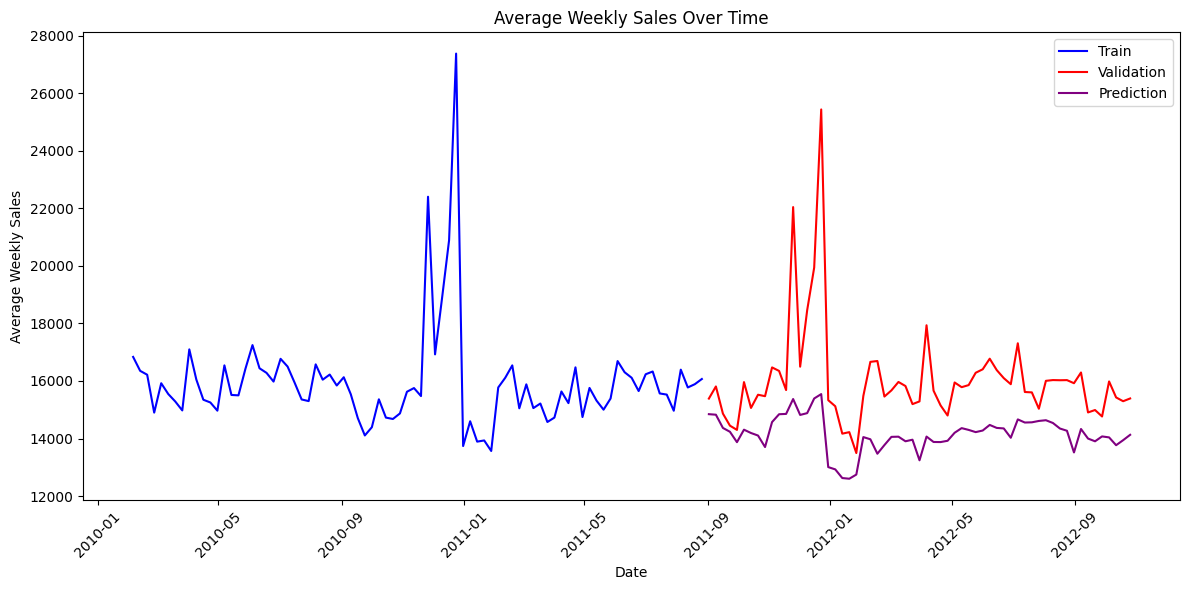

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [21:07:34] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/07 21:07:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_HuberError_Estimator_100_SlopeSearch at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/1d66d95e0a424555a36e965f9578523d
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(best_model)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


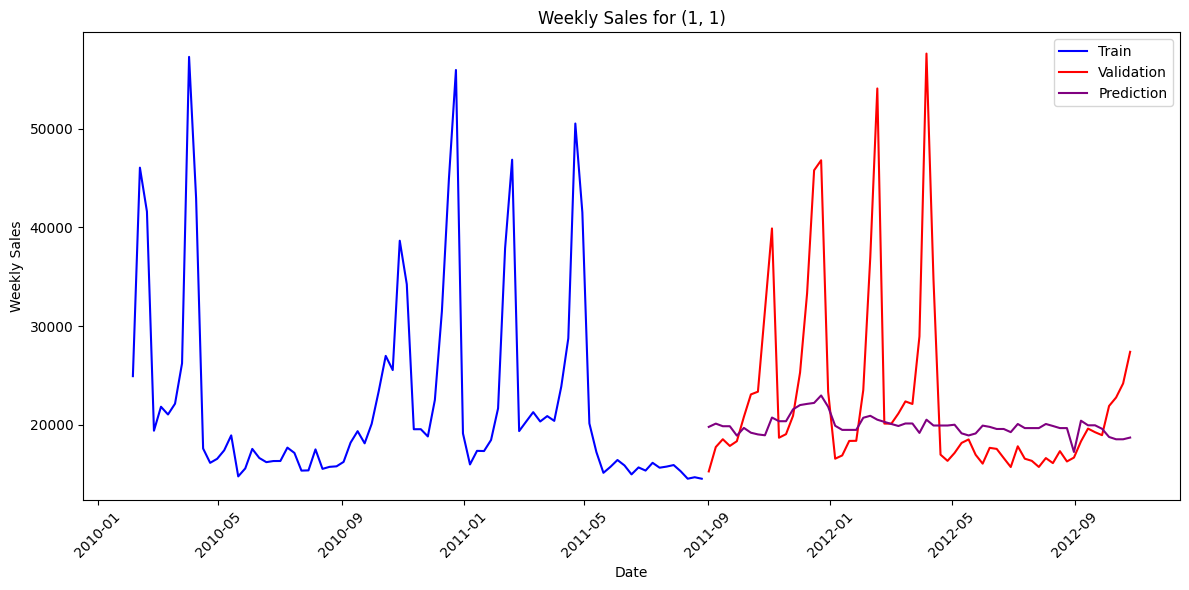

In [ ]:
plot_store_dept(models[-1], 1, 1)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


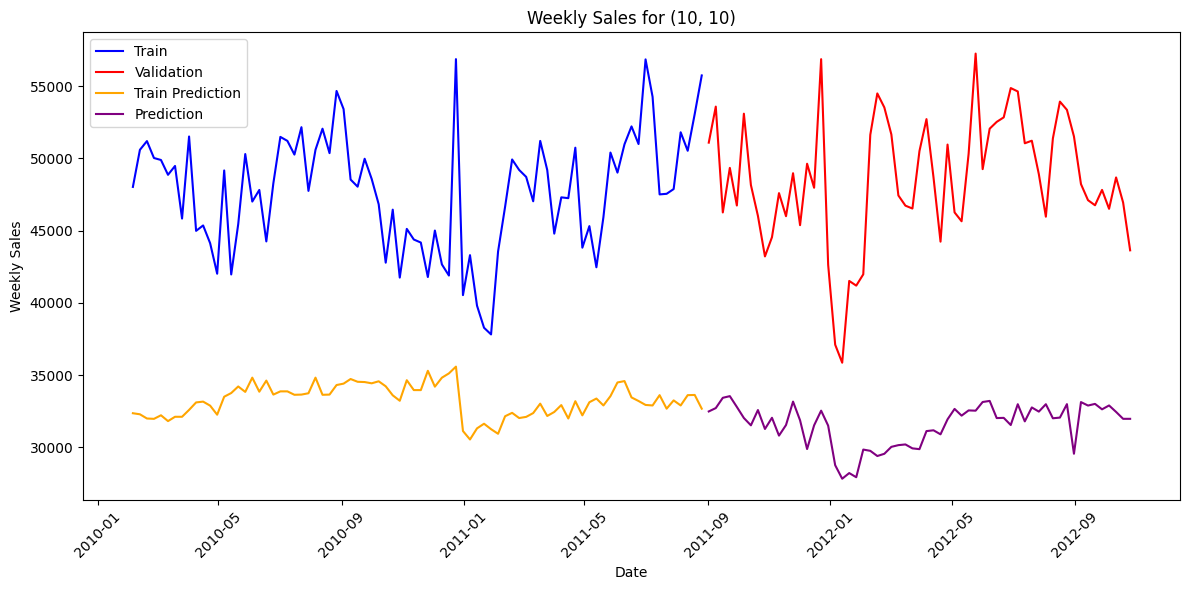

In [ ]:
plot_store_dept(models[-1], 10, 10)

## Experiment 15

In [ ]:
class Model15(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_AbsoluteError_Estimator_300_LowerLR",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
        'eta': 0.07,
      },
      'num_boost_round': 300,
    }

In [ ]:
model15 = Model15(preprocessor_factory=preprocessor_factory1)
model15.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'eta': 0.07}, 'num_boost_round': 300}
[0]	train-mae:12912.94772	train-wmae:12912.94824	test-mae:13249.48656	test-wmae:13249.48633
[1]	train-mae:12432.06154	train-wmae:12432.06152	test-mae:12768.47716	test-wmae:12768.47754
[2]	train-mae:11984.81018	train-wmae:11984.81055	test-mae:12320.20583	test-wmae:12320.20703
[3]	train-mae:11581.97075	train-wmae:11581.97168	test-mae:11913.90445	test-wmae:11913.90430
[4]	train-mae:11214.16462	train-wmae:11214.16504	test-mae:11544.28003	test-wmae:11544.28125
[5]	train-mae:10808.40967	train-wmae:10808.41016	test-mae:11140.58822	test-wmae:11140.58887
[6]	train-mae:10446.83545	train-wmae:10446.83496	test-mae:10784.47465	test-wmae:10784.47461
[7]	train-mae:10158.41698	train-wmae:10158.41602	test-mae:10493.72579	test-wmae:10493.72559
[8]	train-mae:9846.31352	train-wmae:9846.31250	test-mae:10191.50707	test-wmae:10191.50684
[9]	train-mae:9639.14425	train-wmae:9639.14453

Model Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'eta': 0.07}, 'num_boost_round': 300}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 3478.8105230097053, 'mae_test': 3994.1150552844933, 'wmae_train': np.float64(3633.546736965458), 'wmae_test': np.float64(4246.602962894529)}
Model Data {'run_name': 'XGBoost_Obj_AbsoluteError_Estimator_300_LowerLR', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


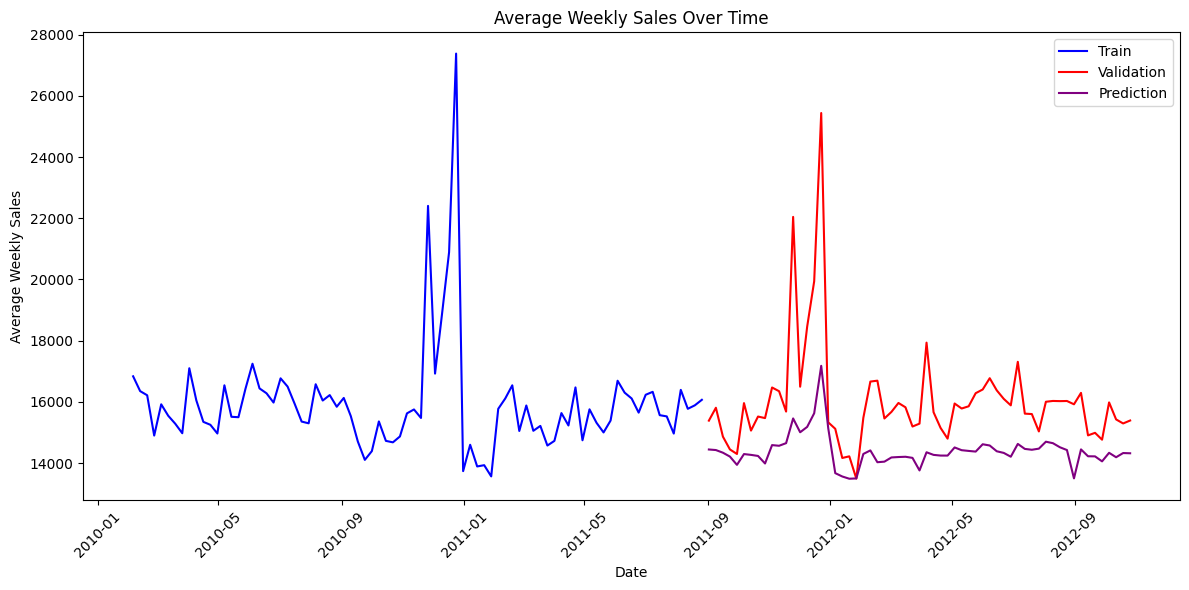

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [13:12:47] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/05 13:12:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_AbsoluteError_Estimator_300_LowerLR at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/b9881f9a1aba4088a854be6961c424be
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model15)

## Experiment 16

In [ ]:
class Model16(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_AbsoluteError_Estimator_300_LR_0.25",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
        'eta': 0.25,
      },
      'num_boost_round': 300,
    }

In [ ]:
model16 = Model16(preprocessor_factory=preprocessor_factory1)
model16.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'eta': 0.25}, 'num_boost_round': 300}
[0]	train-mae:11588.88872	train-wmae:11588.88965	test-mae:11925.86298	test-wmae:11925.86231
[1]	train-mae:10384.56428	train-wmae:10384.56445	test-mae:10707.67002	test-wmae:10707.67188
[2]	train-mae:9651.78125	train-wmae:9651.78125	test-mae:9971.71945	test-wmae:9971.71973
[3]	train-mae:8984.84915	train-wmae:8984.84961	test-mae:9319.84288	test-wmae:9319.84180
[4]	train-mae:8539.55719	train-wmae:8539.55664	test-mae:8879.16074	test-wmae:8879.16016
[5]	train-mae:8264.31183	train-wmae:8264.31250	test-mae:8617.17574	test-wmae:8617.17578
[6]	train-mae:7953.17758	train-wmae:7953.17822	test-mae:8330.61708	test-wmae:8330.61719
[7]	train-mae:7599.31034	train-wmae:7599.31055	test-mae:7978.84194	test-wmae:7978.84131
[8]	train-mae:7283.63191	train-wmae:7283.63281	test-mae:7653.77895	test-wmae:7653.77930
[9]	train-mae:7107.16881	train-wmae:7107.16846	test-mae:7495.45341	test-

Model Training Params {'params': {'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'eta': 0.25}, 'num_boost_round': 300}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 2587.0418436004147, 'mae_test': 3485.106857881862, 'wmae_train': np.float64(2694.6439603335293), 'wmae_test': np.float64(3686.791923130598)}
Model Data {'run_name': 'XGBoost_Obj_AbsoluteError_Estimator_300_LR_0.25', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


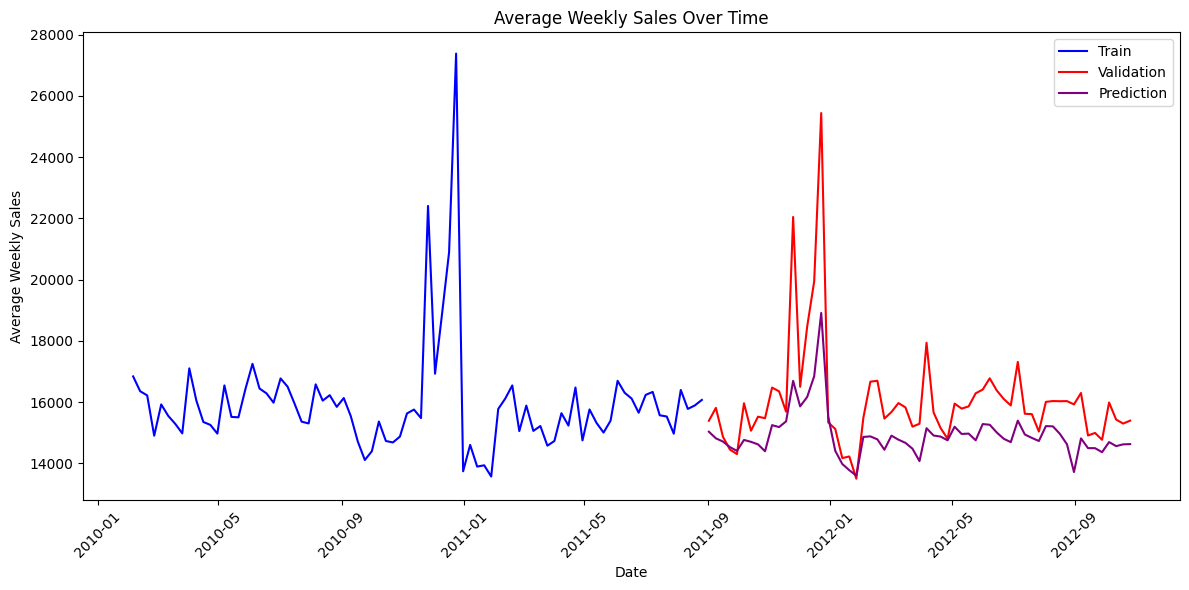

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [13:15:48] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/05 13:15:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_AbsoluteError_Estimator_300_LR_0.25 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/e3bb09c5e10444ccbd5c0e606e51fbda
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model16)

## Experiment 17

In [ ]:
class Model17(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_SquaredError_Estimator_300_LR_0.1",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'eta': 0.1
      },
      'num_boost_round': 300,
    }

In [ ]:
model17 = Model17(preprocessor_factory=preprocessor_factory1)
model17.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'eta': 0.1}, 'num_boost_round': 300}
[0]	train-mae:14146.29116	train-wmae:14146.29102	test-mae:14500.05251	test-wmae:14500.05078
[1]	train-mae:13201.47687	train-wmae:13201.47754	test-mae:13543.19891	test-wmae:13543.19922
[2]	train-mae:12378.45165	train-wmae:12378.45117	test-mae:12712.06668	test-wmae:12712.06543
[3]	train-mae:11648.12892	train-wmae:11648.12891	test-mae:11976.70993	test-wmae:11976.70996
[4]	train-mae:11084.87620	train-wmae:11084.87598	test-mae:11405.55024	test-wmae:11405.54981
[5]	train-mae:10535.50197	train-wmae:10535.50098	test-mae:10859.64651	test-wmae:10859.64648
[6]	train-mae:10092.28077	train-wmae:10092.28027	test-mae:10414.18635	test-wmae:10414.18652
[7]	train-mae:9653.17625	train-wmae:9653.17773	test-mae:9972.51266	test-wmae:9972.51367
[8]	train-mae:9314.83727	train-wmae:9314.83594	test-mae:9630.30864	test-wmae:9630.30957
[9]	train-mae:9023.96698	train-wmae:9023.96680	test-ma

Model Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'eta': 0.1}, 'num_boost_round': 300}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 2826.7671634097796, 'mae_test': 3597.781223745917, 'wmae_train': np.float64(2869.917885768608), 'wmae_test': np.float64(3761.532148493818)}
Model Data {'run_name': 'XGBoost_Obj_SquaredError_Estimator_300_LR_0.1', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


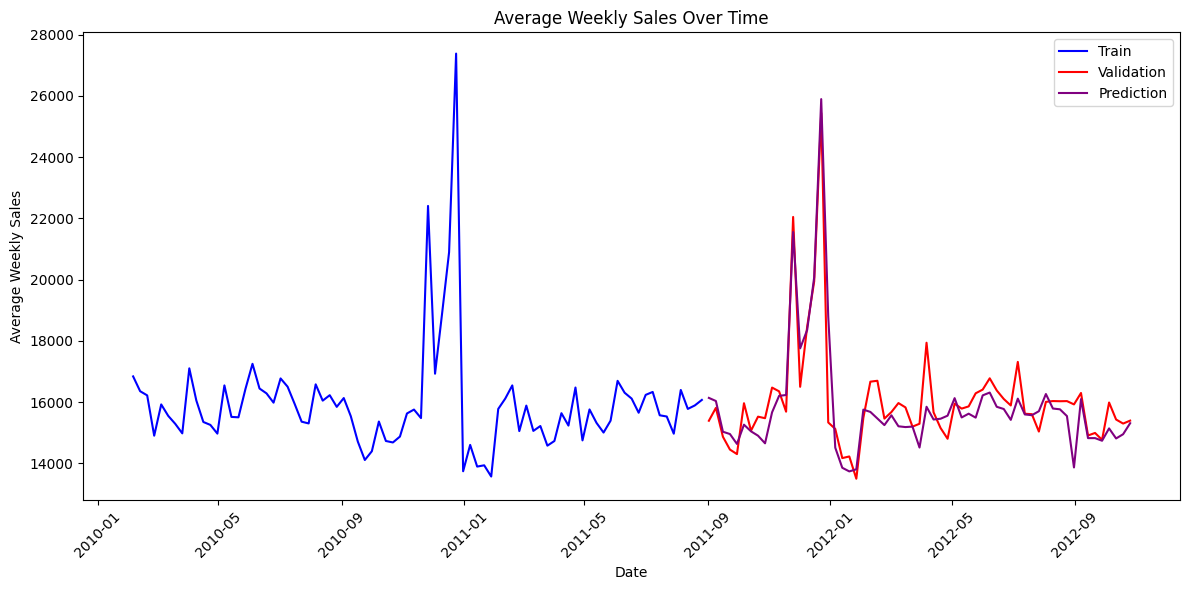

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [13:19:39] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/05 13:19:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_SquaredError_Estimator_300_LR_0.1 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/e583010bf4b44a59a91540a3c47ad393
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model17)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


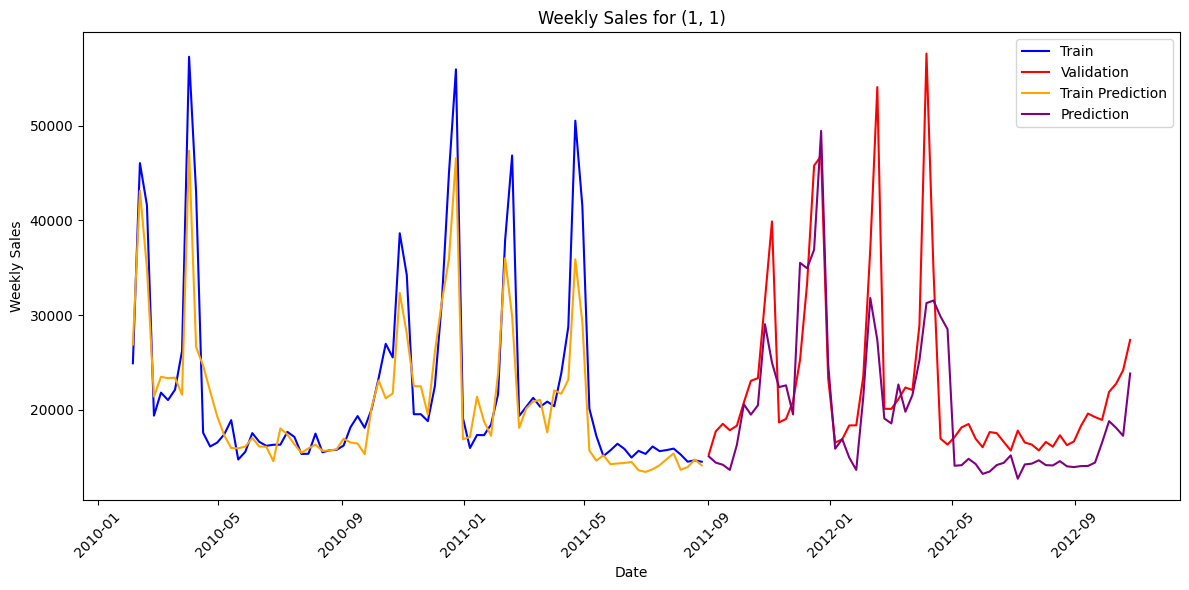

In [ ]:
plot_store_dept(model17, 1, 1)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


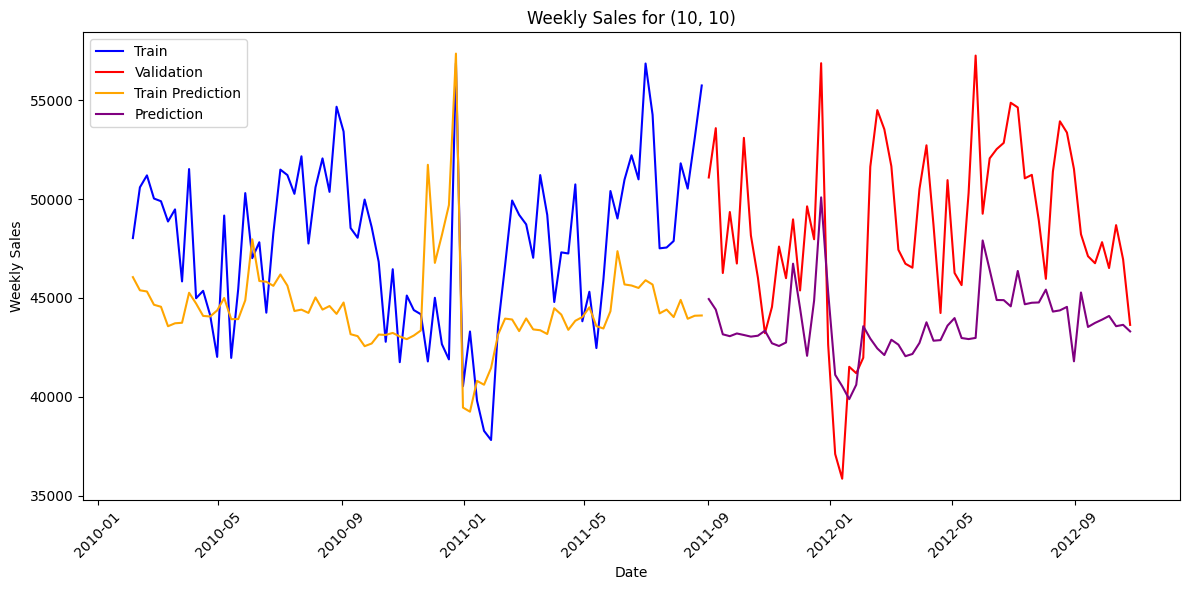

In [ ]:
plot_store_dept(model17, 10, 10)

## Experiment 18

In [ ]:
def factory_generator():
  return preprocessor_factory2(lags=[7*51, 7*52, 7*53])

In [ ]:
class Model18(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_SquaredError_Estimator_300_LR_0.1",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'eta': 0.1
      },
      'num_boost_round': 300,
    }

In [ ]:
X_train[(X_train['Store'] == 1) & (X_train['Dept'] == 77)]

Empty DataFrame
Columns: [Store, Dept, Date, IsHoliday_x, Temperature, Fuel_Price, MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5, CPI, Unemployment, Type, Size]
Index: []

In [ ]:
X_test[(X_test['Store'] == 1) & (X_test['Dept'] == 77)]

Store  Dept       Date  IsHoliday_x  Temperature  Fuel_Price  MarkDown1  \
3369      1    77 2011-11-25         True        60.14       3.236     410.31   
3370      1    77 2011-12-02        False        48.91       3.172    5629.51   
3371      1    77 2012-01-20        False        54.11       3.268    4139.87   

      MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  \
3369      98.00   55805.51       8.00     554.92  218.467621         7.866   
3370      68.00    1398.11    2084.64   20475.32  218.714733         7.866   
3371    2807.19      33.88     500.62    3400.21  219.985689         7.348   

     Type    Size  
3369    A  151315  
3370    A  151315  
3371    A  151315

In [ ]:
model18 = Model18(preprocessor_factory=factory_generator)
model18.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'eta': 0.1}, 'num_boost_round': 300}
[0]	train-mae:14307.60889	train-wmae:14307.60840	test-mae:14336.09898	test-wmae:14336.09863
[1]	train-mae:13517.18444	train-wmae:13517.18262	test-mae:13239.31898	test-wmae:13239.32031
[2]	train-mae:12829.29142	train-wmae:12829.29004	test-mae:12267.08093	test-wmae:12267.08301
[3]	train-mae:12181.88033	train-wmae:12181.87988	test-mae:11390.81869	test-wmae:11390.81836
[4]	train-mae:11629.85967	train-wmae:11629.85938	test-mae:10593.34229	test-wmae:10593.34180
[5]	train-mae:11144.15735	train-wmae:11144.15820	test-mae:9877.84704	test-wmae:9877.84668
[6]	train-mae:10695.24845	train-wmae:10695.24805	test-mae:9229.83885	test-wmae:9229.83789
[7]	train-mae:10310.03410	train-wmae:10310.03418	test-mae:8673.62098	test-wmae:8673.62012
[8]	train-mae:9824.63800	train-wmae:9824.63867	test-mae:8145.42902	test-wmae:8145.42871
[9]	train-mae:9515.33747	train-wmae:9515.33789	test-mae:

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


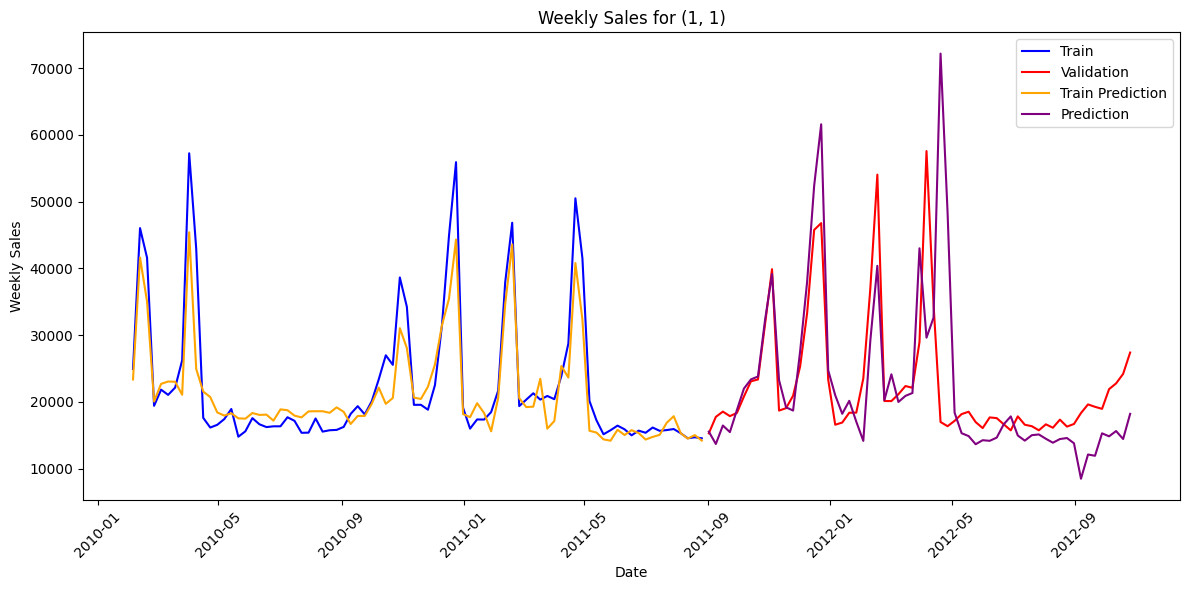

In [ ]:
plot_store_dept(model18, 1, 1)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


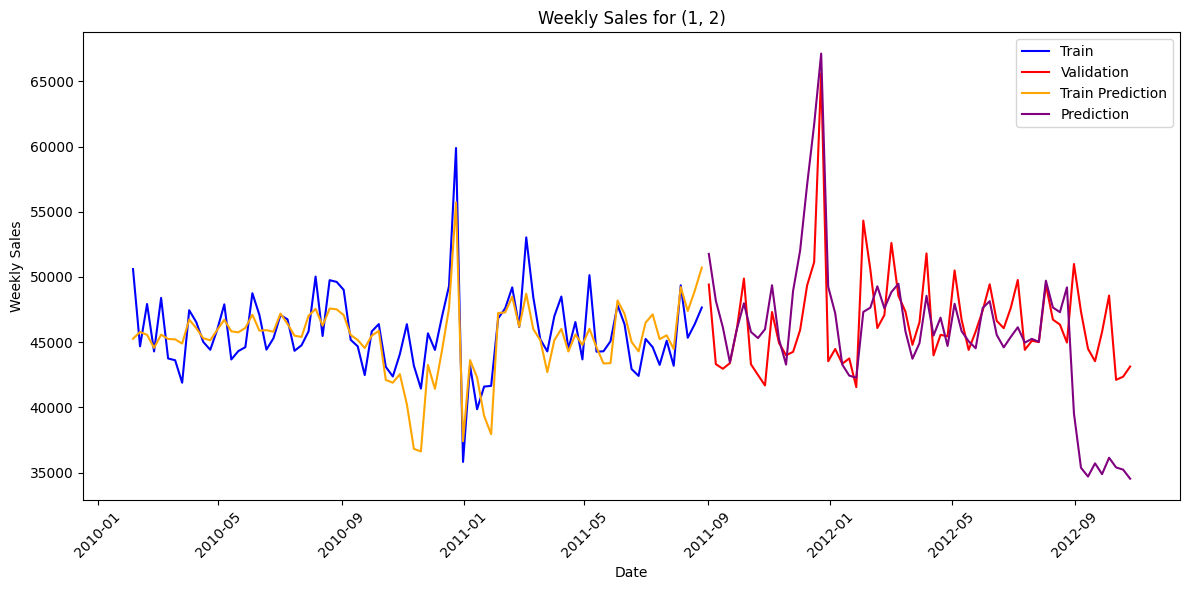

In [ ]:
plot_store_dept(model18, 1, 2)

Model Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'eta': 0.1}, 'num_boost_round': 300}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 2728.242011486581, 'mae_test': 2807.606352043303, 'wmae_train': np.float64(2824.445070695149), 'wmae_test': np.float64(2985.1010091897083)}
Model Data {'run_name': 'XGBoost_Obj_SquaredError_Estimator_300_LR_0.1', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


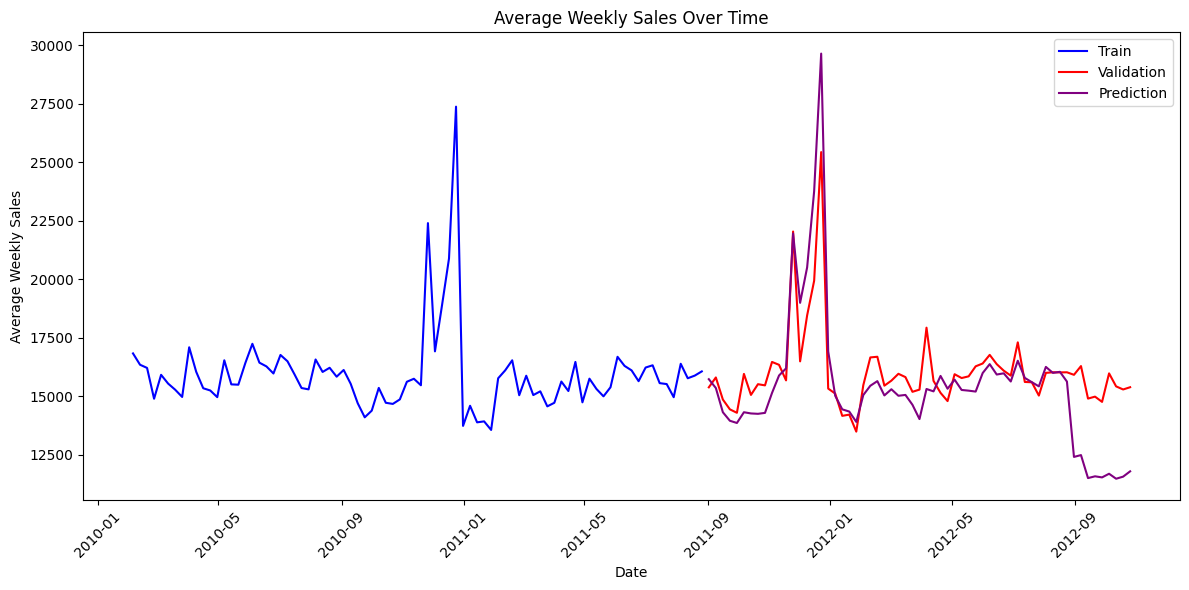

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [18:44:31] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/07 18:44:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Obj_SquaredError_Estimator_300_LR_0.1 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/f4777f720437444a90694bee891bd1cb
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model18)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

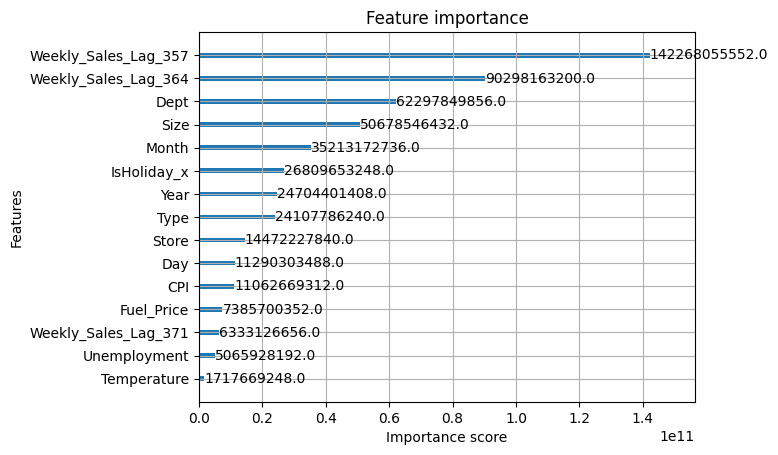

In [ ]:
xgb.plot_importance(model18.model, importance_type='gain')

In [ ]:
import shap
explainer = shap.Explainer(model18.model)

In [ ]:
X_test_processed = factory_generator().transform(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:1424: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


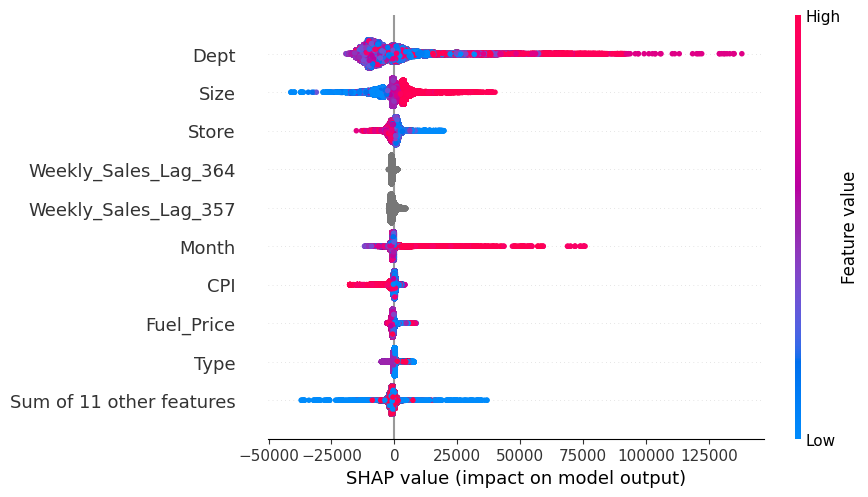

In [ ]:
shap_values = explainer(X_test_processed)
shap.plots.beeswarm(shap_values)

## Experiment 19: Adding Regularization to Best Models

In [ ]:
class Model19(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Obj_SquaredError_Estimator_50",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'alpha': 0,
        'lambda': 100,
        'max_depth':5,
      },
      'num_boost_round': 200,
      'verbose_eval': False,
    }



In [ ]:
result_map = {}

for max_depth in [3, 5]:
  for alpha in [0, 3, 30, 100]:
    for lambda_ in [1, 10, 20, 40, 100, 200]:
      model_config = (max_depth, alpha, lambda_)

      model19 = Model19(preprocessor_factory=preprocessor_factory1)

      model19.train_params['params']['max_depth'] = max_depth
      model19.train_params['params']['alpha'] = alpha
      model19.train_params['params']['lambda'] = lambda_
      model19.train(X_train, y_train, X_test, y_test)

      m = model19.get_metrics(X_train, y_train, X_test, y_test)

      print(model_config, m)

      result_map[model_config] = m

#print(m)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 0, 'lambda': 1, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 0, 1) {'mae_train': 4771.029547365945, 'mae_test': 5173.2510143847785, 'wmae_train': np.float64(4929.709328017161), 'wmae_test': np.float64(5457.797261391684)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 0, 'lambda': 10, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 0, 10) {'mae_train': 4776.592220538083, 'mae_test': 5196.190975305589, 'wmae_train': np.float64(4929.078380063702), 'wmae_test': np.float64(5508.541993279067)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 0, 'lambda': 20, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 0, 20) {'mae_train': 4833.087056430586, 'mae_test': 5275.362878076435, 'wmae_train': np.float64(5010.988180256625), 'wmae_test': np.float64(5544.279701873717)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 0, 'lambda': 40, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 0, 40) {'mae_train': 4839.735816545949, 'mae_test': 5271.685084339268, 'wmae_train': np.float64(5003.426447008255), 'wmae_test': np.float64(5515.638782706686)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 0, 'lambda': 100, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 0, 100) {'mae_train': 4842.934851669623, 'mae_test': 5193.873201896262, 'wmae_train': np.float64(5017.580071062401), 'wmae_test': np.float64(5479.749871302285)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 0, 'lambda': 200, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 0, 200) {'mae_train': 4945.393376649672, 'mae_test': 5330.278216899613, 'wmae_train': np.float64(5111.162754916413), 'wmae_test': np.float64(5576.231675519957)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 3, 'lambda': 1, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 3, 1) {'mae_train': 4771.029812531553, 'mae_test': 5173.251160313712, 'wmae_train': np.float64(4929.709598160432), 'wmae_test': np.float64(5457.797423592932)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 3, 'lambda': 10, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 3, 10) {'mae_train': 4776.592394360052, 'mae_test': 5196.191053512854, 'wmae_train': np.float64(4929.078563235136), 'wmae_test': np.float64(5508.5420596691)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 3, 'lambda': 20, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 3, 20) {'mae_train': 4833.087277183056, 'mae_test': 5275.363007399725, 'wmae_train': np.float64(5010.988417681769), 'wmae_test': np.float64(5544.279857470833)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 3, 'lambda': 40, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 3, 40) {'mae_train': 4839.73605404702, 'mae_test': 5271.685294828048, 'wmae_train': np.float64(5003.42669821718), 'wmae_test': np.float64(5515.639020830286)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 3, 'lambda': 100, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 3, 100) {'mae_train': 4842.935054806658, 'mae_test': 5193.873412027832, 'wmae_train': np.float64(5017.580268043189), 'wmae_test': np.float64(5479.750063546125)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 3, 'lambda': 200, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 3, 200) {'mae_train': 4945.3934989763, 'mae_test': 5330.278263538264, 'wmae_train': np.float64(5111.162886078), 'wmae_test': np.float64(5576.2317456596065)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 30, 'lambda': 1, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 30, 1) {'mae_train': 4771.031524799793, 'mae_test': 5173.25225571573, 'wmae_train': np.float64(4929.711482541491), 'wmae_test': np.float64(5457.798654664074)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 30, 'lambda': 10, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 30, 10) {'mae_train': 4776.5940214448965, 'mae_test': 5196.191911624534, 'wmae_train': np.float64(4929.080319579154), 'wmae_test': np.float64(5508.542963308946)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 30, 'lambda': 20, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 30, 20) {'mae_train': 4833.089054301094, 'mae_test': 5275.364422116237, 'wmae_train': np.float64(5010.990294002149), 'wmae_test': np.float64(5544.281405624218)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 30, 'lambda': 40, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 30, 40) {'mae_train': 4839.737980865338, 'mae_test': 5271.686739084586, 'wmae_train': np.float64(5003.428736645128), 'wmae_test': np.float64(5515.640643144693)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 30, 'lambda': 100, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 30, 100) {'mae_train': 4842.936562825428, 'mae_test': 5193.874778855895, 'wmae_train': np.float64(5017.581888679377), 'wmae_test': np.float64(5479.751459012656)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 30, 'lambda': 200, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 30, 200) {'mae_train': 4945.394841997769, 'mae_test': 5330.2791709077765, 'wmae_train': np.float64(5111.164269239819), 'wmae_test': np.float64(5576.232716123091)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 100, 'lambda': 1, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 100, 1) {'mae_train': 4771.03591356986, 'mae_test': 5173.254820814003, 'wmae_train': np.float64(4929.716327478015), 'wmae_test': np.float64(5457.801558811563)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 100, 'lambda': 10, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 100, 10) {'mae_train': 4776.598586410615, 'mae_test': 5196.194288065671, 'wmae_train': np.float64(4929.085258546925), 'wmae_test': np.float64(5508.545596293654)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 100, 'lambda': 20, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 100, 20) {'mae_train': 4833.093720843781, 'mae_test': 5275.367965354599, 'wmae_train': np.float64(5010.995163091001), 'wmae_test': np.float64(5544.28529759097)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 100, 'lambda': 40, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 100, 40) {'mae_train': 4839.742844487018, 'mae_test': 5271.690423163392, 'wmae_train': np.float64(5003.433938230073), 'wmae_test': np.float64(5515.644777786073)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 100, 'lambda': 100, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 100, 100) {'mae_train': 4842.940823694781, 'mae_test': 5193.878655162364, 'wmae_train': np.float64(5017.586377879966), 'wmae_test': np.float64(5479.755364557295)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 100, 'lambda': 200, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(3, 100, 200) {'mae_train': 4945.398419747205, 'mae_test': 5330.281799087247, 'wmae_train': np.float64(5111.167917112147), 'wmae_test': np.float64(5576.235500993124)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 0, 'lambda': 1, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 0, 1) {'mae_train': 3086.0804118331166, 'mae_test': 3892.57134497046, 'wmae_train': np.float64(3144.938549599457), 'wmae_test': np.float64(4069.567692556906)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 0, 'lambda': 10, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 0, 10) {'mae_train': 3117.2868637453257, 'mae_test': 3899.8122073019013, 'wmae_train': np.float64(3164.924622356079), 'wmae_test': np.float64(4058.0940420184793)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 0, 'lambda': 20, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 0, 20) {'mae_train': 3093.8499596100314, 'mae_test': 3938.637949512554, 'wmae_train': np.float64(3152.0665990512503), 'wmae_test': np.float64(4057.9464020399755)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 0, 'lambda': 40, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 0, 40) {'mae_train': 3129.3446916826842, 'mae_test': 3950.9486290532736, 'wmae_train': np.float64(3201.9274447333382), 'wmae_test': np.float64(4111.947718322917)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 0, 'lambda': 100, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 0, 100) {'mae_train': 3249.0059069814847, 'mae_test': 3988.876825247453, 'wmae_train': np.float64(3319.4380693394214), 'wmae_test': np.float64(4151.744122959989)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 0, 'lambda': 200, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 0, 200) {'mae_train': 3348.435422897194, 'mae_test': 4092.5834989939267, 'wmae_train': np.float64(3416.2351992689005), 'wmae_test': np.float64(4239.482505368463)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 3, 'lambda': 1, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 3, 1) {'mae_train': 3086.0819491237658, 'mae_test': 3892.5712134404525, 'wmae_train': np.float64(3144.9401076654926), 'wmae_test': np.float64(4069.567650769579)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 3, 'lambda': 10, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 3, 10) {'mae_train': 3117.288234337485, 'mae_test': 3899.8124467488856, 'wmae_train': np.float64(3164.92604894796), 'wmae_test': np.float64(4058.0943897628417)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 3, 'lambda': 20, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 3, 20) {'mae_train': 3093.851198367175, 'mae_test': 3938.638407306762, 'wmae_train': np.float64(3152.0678995130784), 'wmae_test': np.float64(4057.946893947656)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 3, 'lambda': 40, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 3, 40) {'mae_train': 3129.345752276172, 'mae_test': 3950.948926790724, 'wmae_train': np.float64(3201.9285781718145), 'wmae_test': np.float64(4111.948085979404)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 3, 'lambda': 100, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 3, 100) {'mae_train': 3249.00683419856, 'mae_test': 3988.8773040111423, 'wmae_train': np.float64(3319.439059235408), 'wmae_test': np.float64(4151.744638027229)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 3, 'lambda': 200, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 3, 200) {'mae_train': 3348.436184889247, 'mae_test': 4092.5838368229697, 'wmae_train': np.float64(3416.235989314615), 'wmae_test': np.float64(4239.482897941228)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 30, 'lambda': 1, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 30, 1) {'mae_train': 3067.7795855052204, 'mae_test': 3897.483695264891, 'wmae_train': np.float64(3123.2437567925012), 'wmae_test': np.float64(4093.313986258511)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 30, 'lambda': 10, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 30, 10) {'mae_train': 3117.300204774889, 'mae_test': 3899.813839168485, 'wmae_train': np.float64(3164.9385251266945), 'wmae_test': np.float64(4058.0966493388164)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 30, 'lambda': 20, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 30, 20) {'mae_train': 3093.86237588591, 'mae_test': 3938.641977446712, 'wmae_train': np.float64(3152.0796676804744), 'wmae_test': np.float64(4057.9508425947556)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 30, 'lambda': 40, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 30, 40) {'mae_train': 3129.35542687332, 'mae_test': 3950.951414323402, 'wmae_train': np.float64(3201.938855525357), 'wmae_test': np.float64(4111.951058961383)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 30, 'lambda': 100, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 30, 100) {'mae_train': 3231.1612826362034, 'mae_test': 3986.9993388161574, 'wmae_train': np.float64(3298.44432076601), 'wmae_test': np.float64(4168.764898226973)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 30, 'lambda': 200, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 30, 200) {'mae_train': 3348.442517636566, 'mae_test': 4092.5862446803926, 'wmae_train': np.float64(3416.242707677208), 'wmae_test': np.float64(4239.48582974284)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 100, 'lambda': 1, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 100, 1) {'mae_train': 3104.896906690438, 'mae_test': 3915.9121581290233, 'wmae_train': np.float64(3150.8564848896212), 'wmae_test': np.float64(4109.519838028428)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 100, 'lambda': 10, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 100, 10) {'mae_train': 3126.8916985961523, 'mae_test': 3912.4420194940076, 'wmae_train': np.float64(3187.761125448437), 'wmae_test': np.float64(4064.3253436753553)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 100, 'lambda': 20, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 100, 20) {'mae_train': 3066.1233983725856, 'mae_test': 3927.564998567181, 'wmae_train': np.float64(3122.2679460368395), 'wmae_test': np.float64(4045.54338027689)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 100, 'lambda': 40, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 100, 40) {'mae_train': 3143.9116093651955, 'mae_test': 3986.037368562614, 'wmae_train': np.float64(3220.9838282122305), 'wmae_test': np.float64(4152.405368372756)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 100, 'lambda': 100, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 100, 100) {'mae_train': 3232.245636295698, 'mae_test': 3980.937689360881, 'wmae_train': np.float64(3293.9630348222236), 'wmae_test': np.float64(4140.49198745338)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 100, 'lambda': 200, 'max_depth': 5}, 'num_boost_round': 200, 'verbose_eval': False}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(5, 100, 200) {'mae_train': 3297.724854623589, 'mae_test': 4023.2171145651996, 'wmae_train': np.float64(3364.238235700727), 'wmae_test': np.float64(4188.504109297583)}


In [ ]:
result_map

{(3, 0, 1): {'mae_train': 4771.029547365945,
  'mae_test': 5173.2510143847785,
  'wmae_train': np.float64(4929.709328017161),
  'wmae_test': np.float64(5457.797261391684)},
 (3, 0, 10): {'mae_train': 4776.592220538083,
  'mae_test': 5196.190975305589,
  'wmae_train': np.float64(4929.078380063702),
  'wmae_test': np.float64(5508.541993279067)},
 (3, 0, 20): {'mae_train': 4833.087056430586,
  'mae_test': 5275.362878076435,
  'wmae_train': np.float64(5010.988180256625),
  'wmae_test': np.float64(5544.279701873717)},
 (3, 0, 40): {'mae_train': 4839.735816545949,
  'mae_test': 5271.685084339268,
  'wmae_train': np.float64(5003.426447008255),
  'wmae_test': np.float64(5515.638782706686)},
 (3, 0, 100): {'mae_train': 4842.934851669623,
  'mae_test': 5193.873201896262,
  'wmae_train': np.float64(5017.580071062401),
  'wmae_test': np.float64(5479.749871302285)},
 (3, 0, 200): {'mae_train': 4945.393376649672,
  'mae_test': 5330.278216899613,
  'wmae_train': np.float64(5111.162754916413),
  'wmae

In [ ]:
min_diff = 99999
best_key = None

for key, value in result_map.items():
  diff = abs(value['wmae_train'] - value['wmae_test'])
  if diff < min_diff:
    min_diff = diff
    best_key = key

print(best_key, min_diff)

(3, 100, 100) 462.1689866773295


In [ ]:
print(result_map[(3, 100, 100)])

{'mae_train': 4842.940823694781, 'mae_test': 5193.878655162364, 'wmae_train': np.float64(5017.586377879966), 'wmae_test': np.float64(5479.755364557295)}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


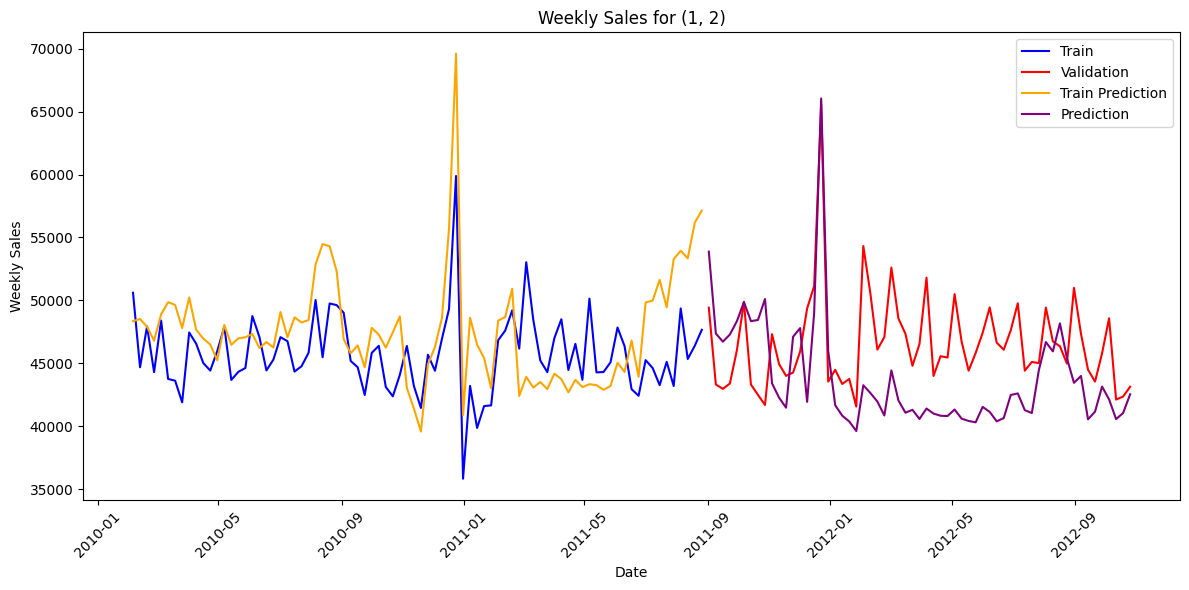

In [ ]:
plot_store_dept(model19, 1, 2)

In [ ]:
class Model19(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Estimator_200_L1_100_L2_100_Depth_3",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'alpha': 100,
        'lambda': 100,
        'max_depth':3,
      },
      'num_boost_round': 200,
      'verbose_eval': True,
    }



In [ ]:
model19 = Model19(preprocessor_factory=preprocessor_factory1)
model19.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 100, 'lambda': 100, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': True}
[0]	train-mae:13598.07882	train-wmae:13598.07812	test-mae:13946.56877	test-wmae:13946.56934
[1]	train-mae:12613.58608	train-wmae:12613.58594	test-mae:12954.34846	test-wmae:12954.34766
[2]	train-mae:11987.98887	train-wmae:11987.98926	test-mae:12323.53774	test-wmae:12323.53809
[3]	train-mae:10964.98752	train-wmae:10964.98731	test-mae:11297.00751	test-wmae:11297.00781
[4]	train-mae:10518.05005	train-wmae:10518.04981	test-mae:10828.70974	test-wmae:10828.71094
[5]	train-mae:10268.02049	train-wmae:10268.02051	test-mae:10579.19668	test-wmae:10579.19434
[6]	train-mae:10038.25967	train-wmae:10038.26074	test-mae:10346.81317	test-wmae:10346.81250
[7]	train-mae:9769.53243	train-wmae:9769.53223	test-mae:10074.39573	test-wmae:10074.39551
[8]	train-mae:9217.65686	train-wmae:9217.65723	test-mae:9519.82905	test-wmae:9519.830

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


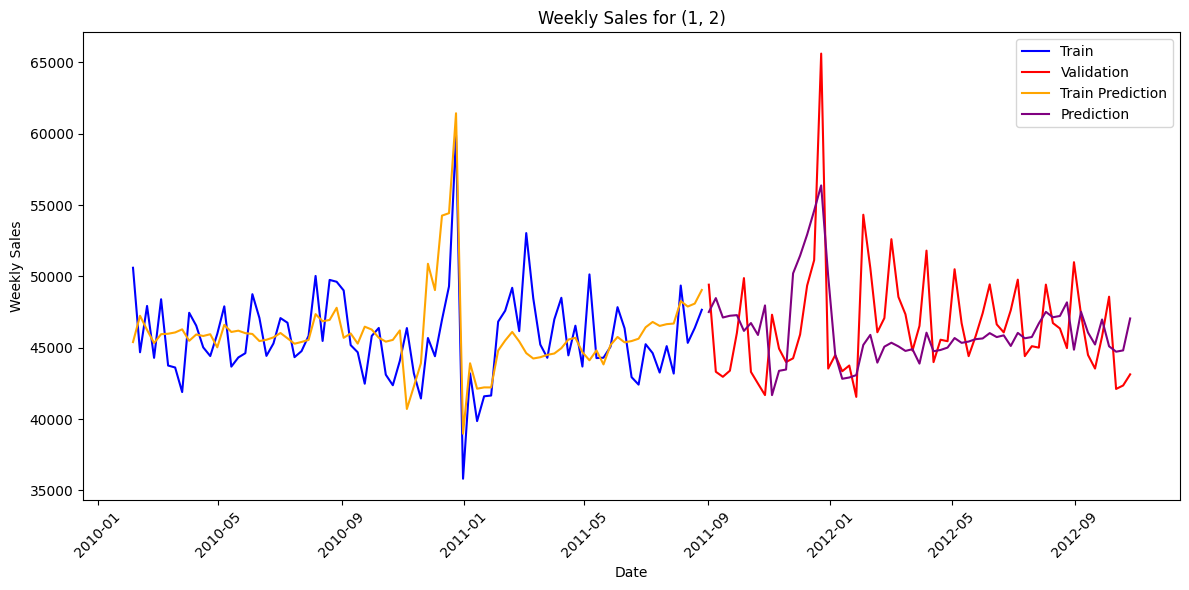

In [ ]:
plot_store_dept(model19, 1, 2)

Model Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 100, 'lambda': 100, 'max_depth': 3}, 'num_boost_round': 200, 'verbose_eval': True}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 4842.940823694781, 'mae_test': 5193.878655162364, 'wmae_train': np.float64(5017.586377879966), 'wmae_test': np.float64(5479.755364557295)}
Model Data {'run_name': 'XGBoost_Estimator_200_L1_100_L2_100_Depth_3', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


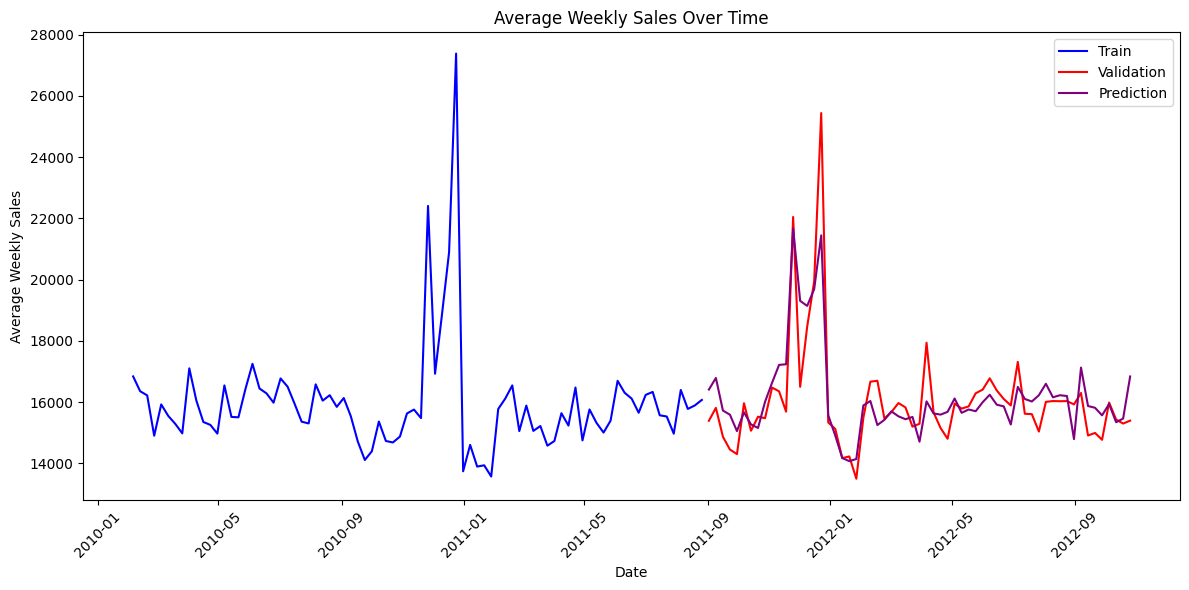

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [22:10:30] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/07 22:10:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Estimator_200_L1_100_L2_100_Depth_3 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/33586c9faf314360b3189cae1fbdeab6
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model19)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

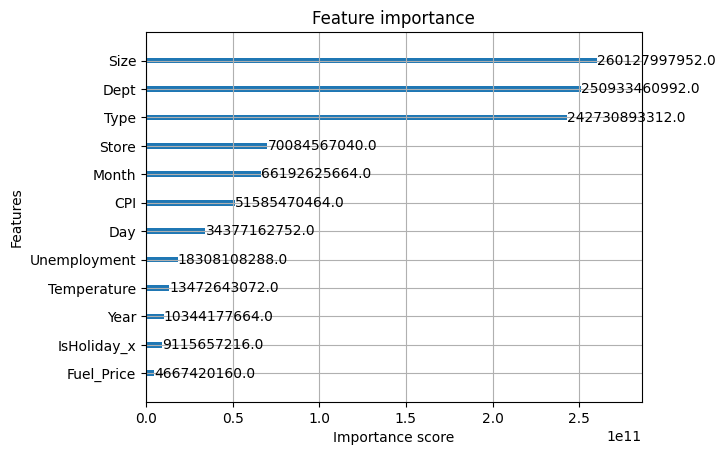

In [ ]:
xgb.plot_importance(model19.model, importance_type='gain')

In [ ]:
class Model20(BaseModel):
  def model_data(self):
    return {
        "run_name": "XGBoost_Estimator_500_L1_100_L2_100_Depth_3",
        "artifacts": ["prediction.png"],
    }

  def init_train_params(self):
    return {
      'params': {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'alpha': 100,
        'lambda': 100,
        'max_depth':3,
      },
      'num_boost_round': 500,
      'verbose_eval': True,
    }

model20 = Model20(preprocessor_factory=preprocessor_factory3)
model20.train(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Using Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 100, 'lambda': 100, 'max_depth': 3}, 'num_boost_round': 500, 'verbose_eval': True}
[0]	train-mae:13598.07882	train-wmae:13598.07812	test-mae:13946.56877	test-wmae:13946.56934
[1]	train-mae:12633.55721	train-wmae:12633.55859	test-mae:12964.45305	test-wmae:12964.45215
[2]	train-mae:12033.93784	train-wmae:12033.93945	test-mae:12359.26263	test-wmae:12359.26269
[3]	train-mae:11018.95785	train-wmae:11018.95703	test-mae:11340.42807	test-wmae:11340.42773
[4]	train-mae:10591.41820	train-wmae:10591.41894	test-mae:10908.64231	test-wmae:10908.64356
[5]	train-mae:10340.83391	train-wmae:10340.83398	test-mae:10659.18559	test-wmae:10659.18555
[6]	train-mae:10104.28160	train-wmae:10104.28223	test-mae:10415.77566	test-wmae:10415.77734
[7]	train-mae:9574.22895	train-wmae:9574.22949	test-mae:9875.93888	test-wmae:9875.94043
[8]	train-mae:9356.85697	train-wmae:9356.85742	test-mae:9650.75089	test-wmae:9650.75000

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


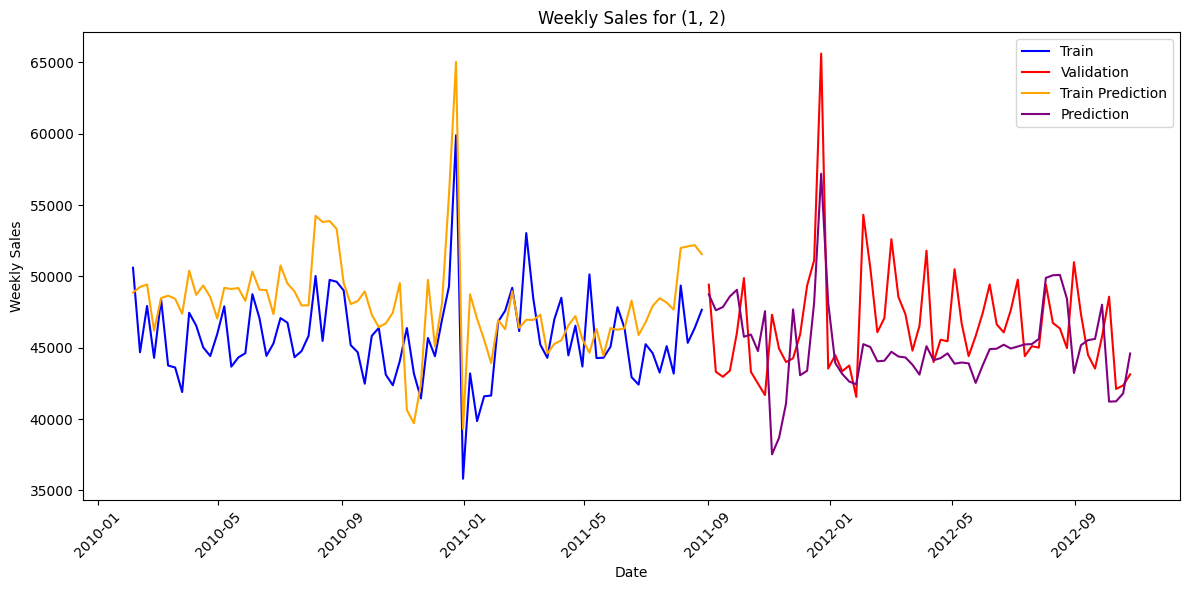

In [ ]:
plot_store_dept(model20, 1, 2)

Model Training Params {'params': {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'alpha': 100, 'lambda': 100, 'max_depth': 3}, 'num_boost_round': 500, 'verbose_eval': True}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Metrics {'mae_train': 4342.149232547971, 'mae_test': 4822.6809098066, 'wmae_train': np.float64(4464.185359547834), 'wmae_test': np.float64(5068.059479452587)}
Model Data {'run_name': 'XGBoost_Estimator_500_L1_100_L2_100_Depth_3', 'artifacts': ['prediction.png']}


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


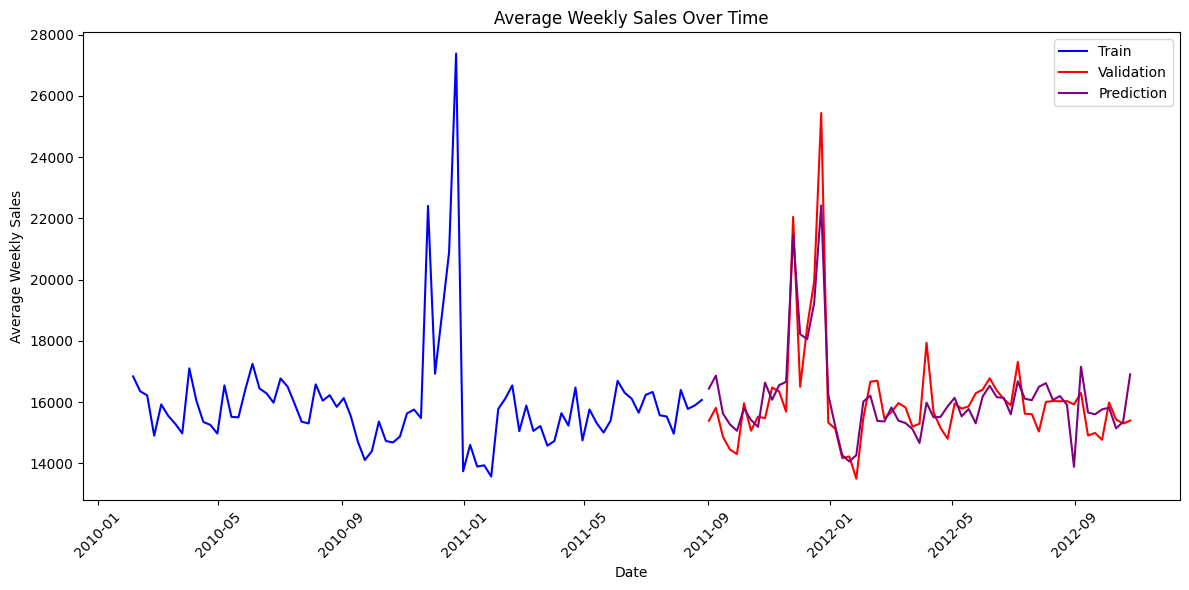

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [22:25:22] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/07 22:25:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Estimator_500_L1_100_L2_100_Depth_3 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/80cfc38226a843f397b4f02eab48d648
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
log_experiment(model20)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

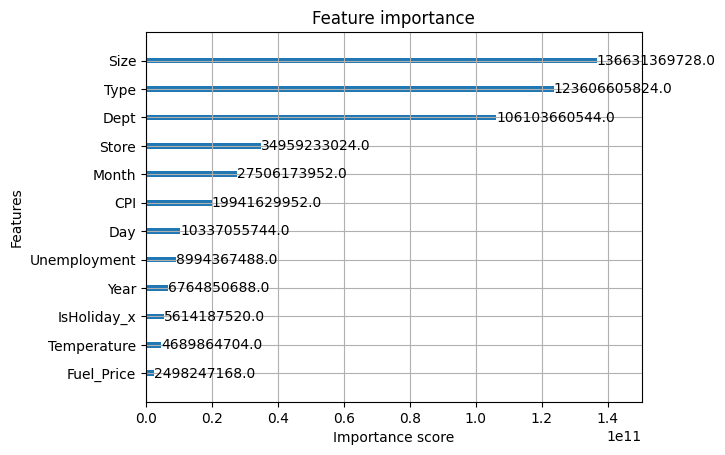

In [ ]:
xgb.plot_importance(model20.model, importance_type='gain')

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

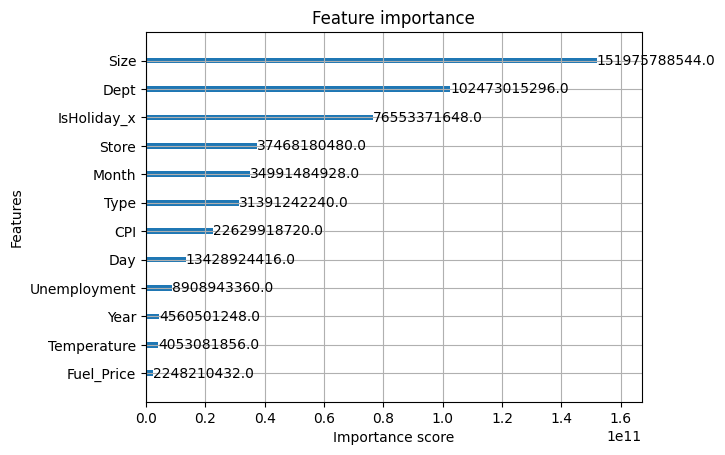

In [ ]:
xgb.plot_importance(model20.model, importance_type='gain')

In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.Explainer(model20.model)

In [ ]:
X_test_processed = preprocessor_factory3().transform(X_test)
shap_values = explainer(X_test_processed)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


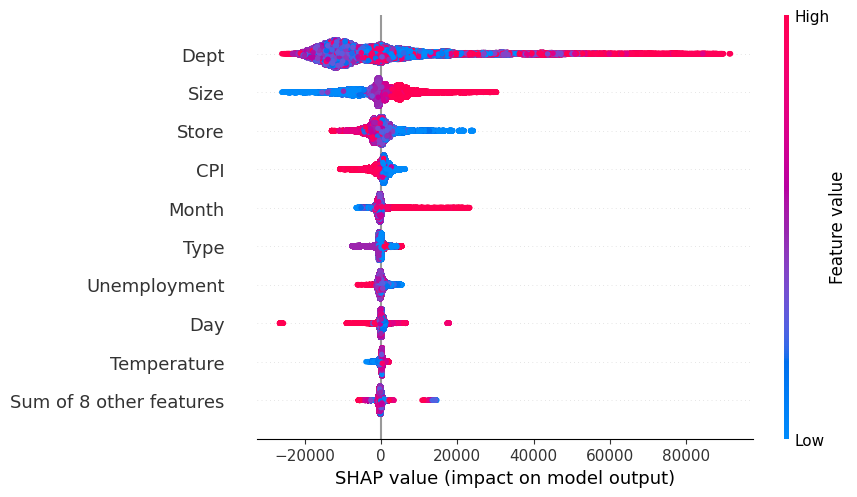

In [ ]:
shap.plots.beeswarm(shap_values)

## Experiment 21: Total Dataset Fit

In [ ]:
X_total_processed = lags_pipeline.transform(X_total)
X_total_processed.head()

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Store  Dept  IsHoliday_x  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1     1            0        42.31       2.572        NaN        NaN   
1      1     1            1        38.51       2.548        NaN        NaN   
2      1     1            0        39.93       2.514        NaN        NaN   
3      1     1            0        46.63       2.561        NaN        NaN   
4      1     1            0        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  Type    Size  \
0        NaN        NaN        NaN  211.096358         8.106     0  151315   
1        NaN        NaN        NaN  211.242170         8.106     0  151315   
2        NaN        NaN        NaN  211.289143         8.106     0  151315   
3        NaN        NaN        NaN  211.319643         8.106     0  151315   
4        NaN        NaN        NaN  211.350143         8.106     0  151315   

   Weekly_Sales_Lag_357  Weekly_Sales_Lag_364  Weekly_Sales_Lag_371  Year  \
0                   NaN                   NaN                   NaN  2010   
1                   NaN                   NaN                   NaN  2010   
2                   NaN                   NaN                   NaN  2010   
3                   NaN                   NaN                   NaN  2010   
4                   NaN                   NaN                   NaN  2010   

   Month  Day  
0      2    5  
1      2   12  
2      2   19  
3      2   26  
4      3    5

In [ ]:
X_total_processed.tail(10)

Store  Dept  IsHoliday_x  Temperature  Fuel_Price  MarkDown1  \
421560     45    98            0        72.62       3.834    7936.20   
421561     45    98            0        75.09       3.867   23641.30   
421562     45    98            1        75.70       3.911   11024.45   
421563     45    98            0        67.87       3.948   11407.95   
421564     45    98            0        65.32       4.038    8452.20   
421565     45    98            0        64.88       3.997    4556.61   
421566     45    98            0        64.89       3.985    5046.74   
421567     45    98            0        54.47       4.000    1956.28   
421568     45    98            0        56.47       3.969    2004.02   
421569     45    98            0        58.85       3.882    4018.91   

        MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  \
421560      58.38      22.00    5518.07    2291.97  191.344887         8.684   
421561       6.00      92.93    6988.31    3992.13  191.461281         8.684   
421562      12.80      52.63    1854.77    2055.70  191.577676         8.684   
421563        NaN       4.30    3421.72    5268.92  191.699850         8.684   
421564      92.28      63.24    2376.38    8670.40  191.856704         8.684   
421565      20.64       1.50    1601.01    3288.25  192.013558         8.684   
421566        NaN      18.82    2253.43    2340.01  192.170412         8.667   
421567        NaN       7.89     599.32    3990.54  192.327265         8.667   
421568        NaN       3.18     437.73    1537.49  192.330854         8.667   
421569      58.08     100.00     211.94     858.33  192.308899         8.667   

        Type    Size  Weekly_Sales_Lag_357  Weekly_Sales_Lag_364  \
421560     1  118221                601.42                385.96   
421561     1  118221               1092.66                601.42   
421562     1  118221                791.96               1092.66   
421563     1  118221                655.12                791.96   
421564     1  118221                727.05                655.12   
421565     1  118221                894.98                727.05   
421566     1  118221                996.40                894.98   
421567     1  118221               1058.84                996.40   
421568     1  118221               1167.90               1058.84   
421569     1  118221                749.18               1167.90   

        Weekly_Sales_Lag_371  Year  Month  Day  
421560                535.68  2012      8   24  
421561                385.96  2012      8   31  
421562                601.42  2012      9    7  
421563               1092.66  2012      9   14  
421564                791.96  2012      9   21  
421565                655.12  2012      9   28  
421566                727.05  2012     10    5  
421567                894.98  2012     10   12  
421568                996.40  2012     10   19  
421569               1058.84  2012     10   26

In [ ]:
# Convert to xgboost matrices
dtotal = xgb.DMatrix(X_total_processed, label=y_total)

In [ ]:
weights_total = X_total_processed['IsHoliday_x'].apply(lambda x: 5 if x else 1).to_numpy()

In [ ]:
dtotal.set_info(weight=weights_total)

In [ ]:
train_params =  {
  'params': {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'eta': 0.1
  },
  'num_boost_round': 300,
}

model21 = xgb.train(
    **train_params,
    custom_metric=wmae_eval,
    dtrain=dtotal,
    evals=[(dtotal, 'train')],
)

[0]	train-mae:14303.26395	train-wmae:14303.26172
[1]	train-mae:13311.51681	train-wmae:13311.51367
[2]	train-mae:12410.73725	train-wmae:12410.73926
[3]	train-mae:11605.62727	train-wmae:11605.62793
[4]	train-mae:10889.75028	train-wmae:10889.75195
[5]	train-mae:10255.65439	train-wmae:10255.65332
[6]	train-mae:9613.54757	train-wmae:9613.54590
[7]	train-mae:9096.81190	train-wmae:9096.81250
[8]	train-mae:8629.08855	train-wmae:8629.08887
[9]	train-mae:8224.95517	train-wmae:8224.95703
[10]	train-mae:7856.23943	train-wmae:7856.23828
[11]	train-mae:7530.28439	train-wmae:7530.28467
[12]	train-mae:7242.28873	train-wmae:7242.28906
[13]	train-mae:6907.85511	train-wmae:6907.85645
[14]	train-mae:6673.61117	train-wmae:6673.61133
[15]	train-mae:6465.40884	train-wmae:6465.40820
[16]	train-mae:6263.08254	train-wmae:6263.08252
[17]	train-mae:6079.52525	train-wmae:6079.52344
[18]	train-mae:5933.79788	train-wmae:5933.79834
[19]	train-mae:5712.04639	train-wmae:5712.04688
[20]	train-mae:5597.37137	train-wmae:5

In [ ]:
import mlflow
mlflow.set_experiment("XGBoost_Training")
mlflow.set_tracking_uri("https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow")

with mlflow.start_run(run_name="XGBoost_LagsFeats_TotalFit"):
    mlflow.log_params(train_params)
    mlflow.log_metrics({})
    mlflow.xgboost.log_model(model21, "XGBoost Model")

/usr/local/lib/python3.11/dist-packages/mlflow/xgboost/__init__.py:168: UserWarning: [01:36:14] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/08 01:36:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_LagsFeats_TotalFit at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4/runs/fb510eb1519a4901bb00f052e2819aff
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/4


## Run this to save the notebook to DagsHub 👇

In [ ]:
from dagshub.notebook import save_notebook

save_notebook(repo="Cimbir/Store-Sales-Forecasting", path=".")

Uploading files (1) to "Cimbir/Store-Sales-Forecasting"...

Upload finished successfully!